In [1]:
import jax
jax.config.update("jax_enable_x64", True)


import matplotlib.pyplot as plt
from matplotlib import colormaps, colors

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

In [2]:
from amigo.files import get_files
from amigo.files import summarise_files

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    [
        "/Users/louis/Data/JWST/amigo_data/CAL04481/calslope/",
    ],
    "calslope",
    EXP_TYPE="NIS_AMI",
    IS_PSF=[True],  # Calibrators
    **kwargs,
)

files = [
    file_fn(FILTER="F380M")[0],
    file_fn(FILTER="F430M")[0],
    file_fn(FILTER="F480M")[0],
]

files = files[:1]

print(f"\n{len(files)}")
summarise_files(
    files,
    ["TARGPROP", "FILTER", "NINTS", "NGROUPS", "OBSERVTN", "NCHUNKS"],
)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-063 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-065
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf



1
  TARGPROP: HD-41094
  FILTER: F380M
  NINTS: 1060
  NGROUPS: 11
  OBSERVTN: 001
  NCHUNKS: 1


In [3]:
import jax.numpy as np

for file in files:
    file["SCI"].data[:, :, -1:] = np.nan
    file["SCI_VAR"].data[:, :, -1:] = np.nan
    file["ZPOINT"].data[:, -1:] = np.nan
    file["ZPOINT_VAR"].data[:, -1:] = np.nan

    file["SCI"].data[:, 41:43, 1] = np.nan

jw04481001001_03104_00003_0001_nis_calslope.fits
1060
11
1164.3608686377156


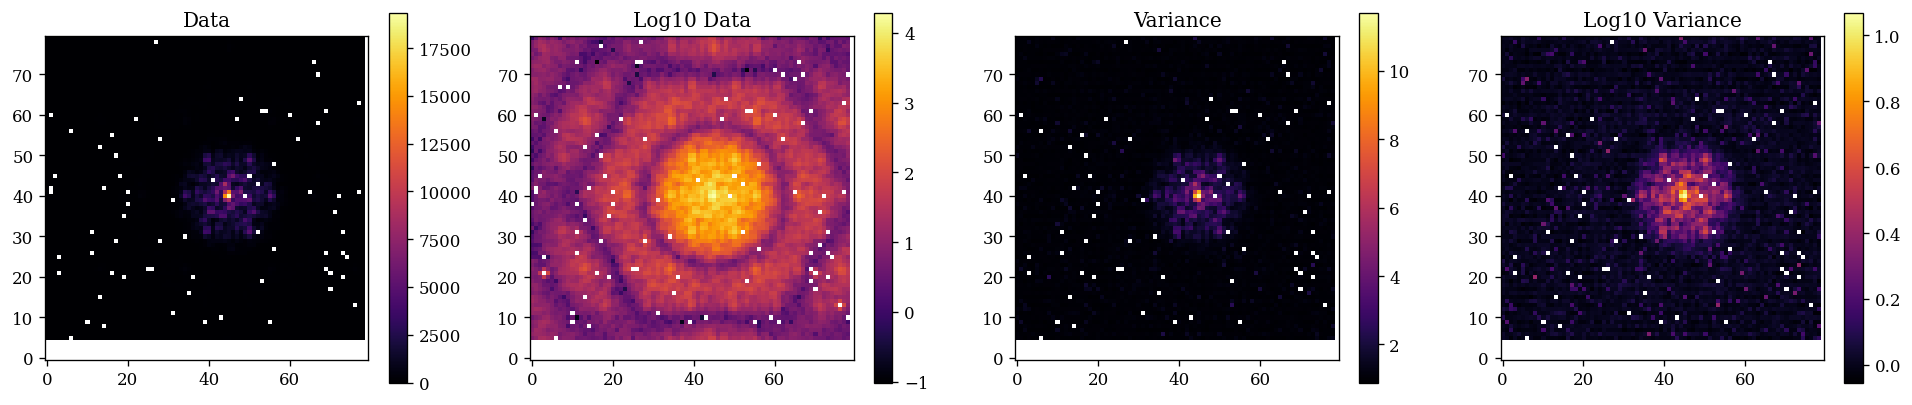

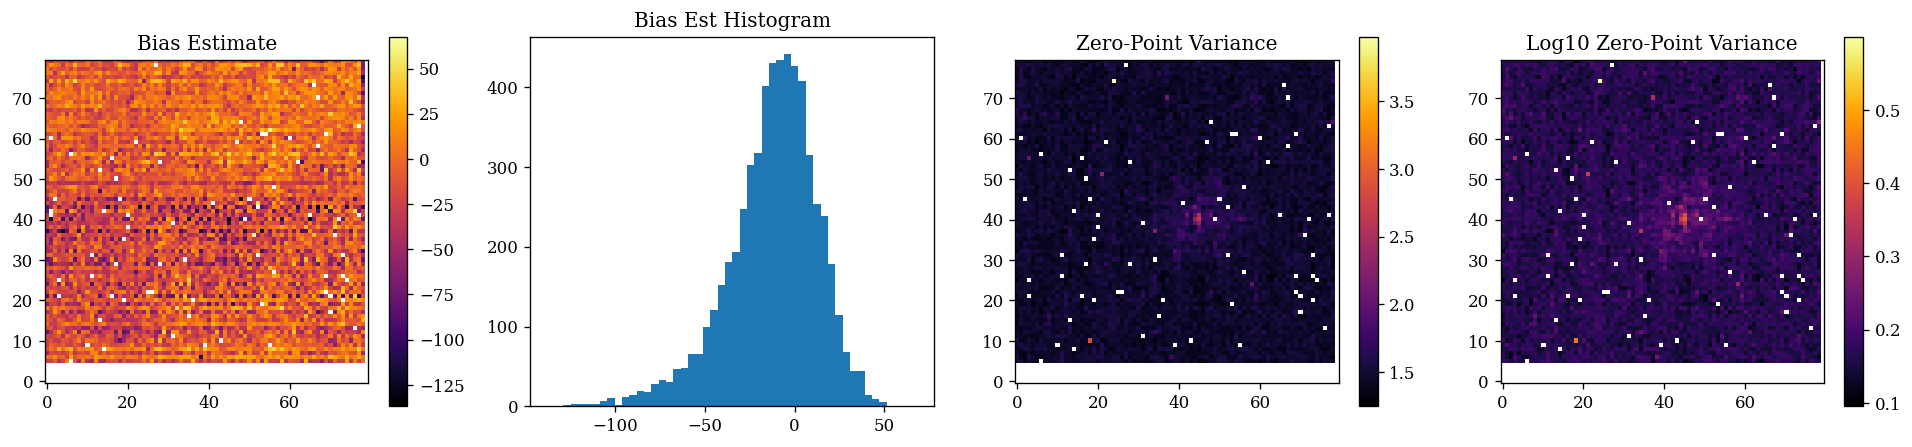

In [4]:
import jax.numpy as np

for file in files:
    print(file[0].header["FILENAME"])
    nints = file[0].header["NINTS"]
    ngroups = file[0].header["NGROUPS"]
    print(nints)
    print(ngroups)

    # data = np.nansum(np.abs(np.asarray(file["SCI"].data, float)), 0)
    data = np.sum(np.asarray(file["SCI"].data, float), 0)
    var = np.sum(np.asarray(file["SCI_VAR"].data, float), 0)

    nphot_per_im = np.nansum(data)
    nphot_tot = nints * nphot_per_im
    print(nphot_tot * 1e-6)

    plt.figure(figsize=(20, 4))
    plt.subplot(1, 4, 1)
    plt.title("Data")
    plt.imshow(data)
    plt.colorbar()

    plt.subplot(1, 4, 2)
    plt.title("Log10 Data")
    plt.imshow(np.log10(data))
    plt.colorbar()

    plt.subplot(1, 4, 3)
    plt.title("Variance")
    # plt.imshow(file["SCI_VAR"].data.sum(0) * nints)
    plt.imshow(var)
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.title("Log10 Variance")
    # plt.imshow(np.log10(file["SCI_VAR"].data.sum(0) * nints))
    plt.imshow(np.log10(var))
    plt.colorbar()
    plt.show()

    # data = np.nansum(np.abs(np.asarray(file["SCI"].data, float)), 0)
    psf_est = np.asarray(file["SCI"].data, float)[0]
    # var = np.sum(np.asarray(file["SCI_VAR"].data, float), 0)
    zpoint = np.asarray(file["ZPOINT"].data, float)
    zpoint_var = np.asarray(file["ZPOINT_VAR"].data, float)

    plt.figure(figsize=(20, 4))
    plt.subplot(1, 4, 1)
    plt.title("Bias Estimate")
    plt.imshow(zpoint - psf_est)
    plt.colorbar()

    plt.subplot(1, 4, 2)
    plt.title("Bias Est Histogram")
    # plt.imshow(np.log10(zpoint - psf_est))
    plt.hist((zpoint - psf_est).flatten(), bins=50)

    plt.subplot(1, 4, 3)
    plt.title("Zero-Point Variance")
    # plt.imshow(file["SCI_VAR"].data.sum(0) * nints)
    plt.imshow(zpoint_var)
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.title("Log10 Zero-Point Variance")
    # plt.imshow(np.log10(file["SCI_VAR"].data.sum(0) * nints))
    plt.imshow(np.log10(zpoint_var))
    plt.colorbar()
    plt.show()

In [5]:
import jax.numpy as np
from amigo.core import SUB80Ramp, AmigoModel, AMIOptics
from amigo.BFE import GradientPolyBFE
from amigo.files import (
    get_Teffs,
    get_filters,
    get_exposures,
    initialise_params,
)

# Get dLux optical system
optics = AMIOptics()

# Get detector
detector = SUB80Ramp()

# # Get BFE
# EDM = GradientPolyBFE(
#     ksize=3, oversample=4, orders=[1, 2, 3], conserved=False, use_psf=True
# )

# Get initial Exposures
ms_thresh = -5  # nan everything with an average slope <= -5
exposures = get_exposures(files, ms_thresh=ms_thresh)

# TODO: Build a local cache or config file to store Teffs to avoid searching databases
# Prep the model
params = initialise_params(exposures, optics)
Teffs = get_Teffs(files)
filters = get_filters(files)
model = AmigoModel(params, optics, detector, Teffs, filters)

In [6]:
def build_image_basis(image):
    ygrads, xgrads = np.gradient(image)
    rgrads = np.hypot(xgrads, ygrads)

    yygrads = np.gradient(ygrads)[0]
    xxgrads = np.gradient(xgrads)[1]
    xxyygrads = yygrads + xxgrads

    xyrgrads = np.hypot(xxgrads, yygrads)

    return np.array([image, rgrads, xyrgrads, xxyygrads])


def build_basis(image, powers = [1, 2], norm=1900.0):
    image /= norm
    safe_pow = lambda x, p: np.where(x < 0, -np.abs(np.pow(-x, p)), np.pow(x, p))
    images = [safe_pow(image, pow) for pow in powers]
    basis = [build_image_basis(im) for im in images]
    return np.concatenate(basis)

(8, 320, 320)


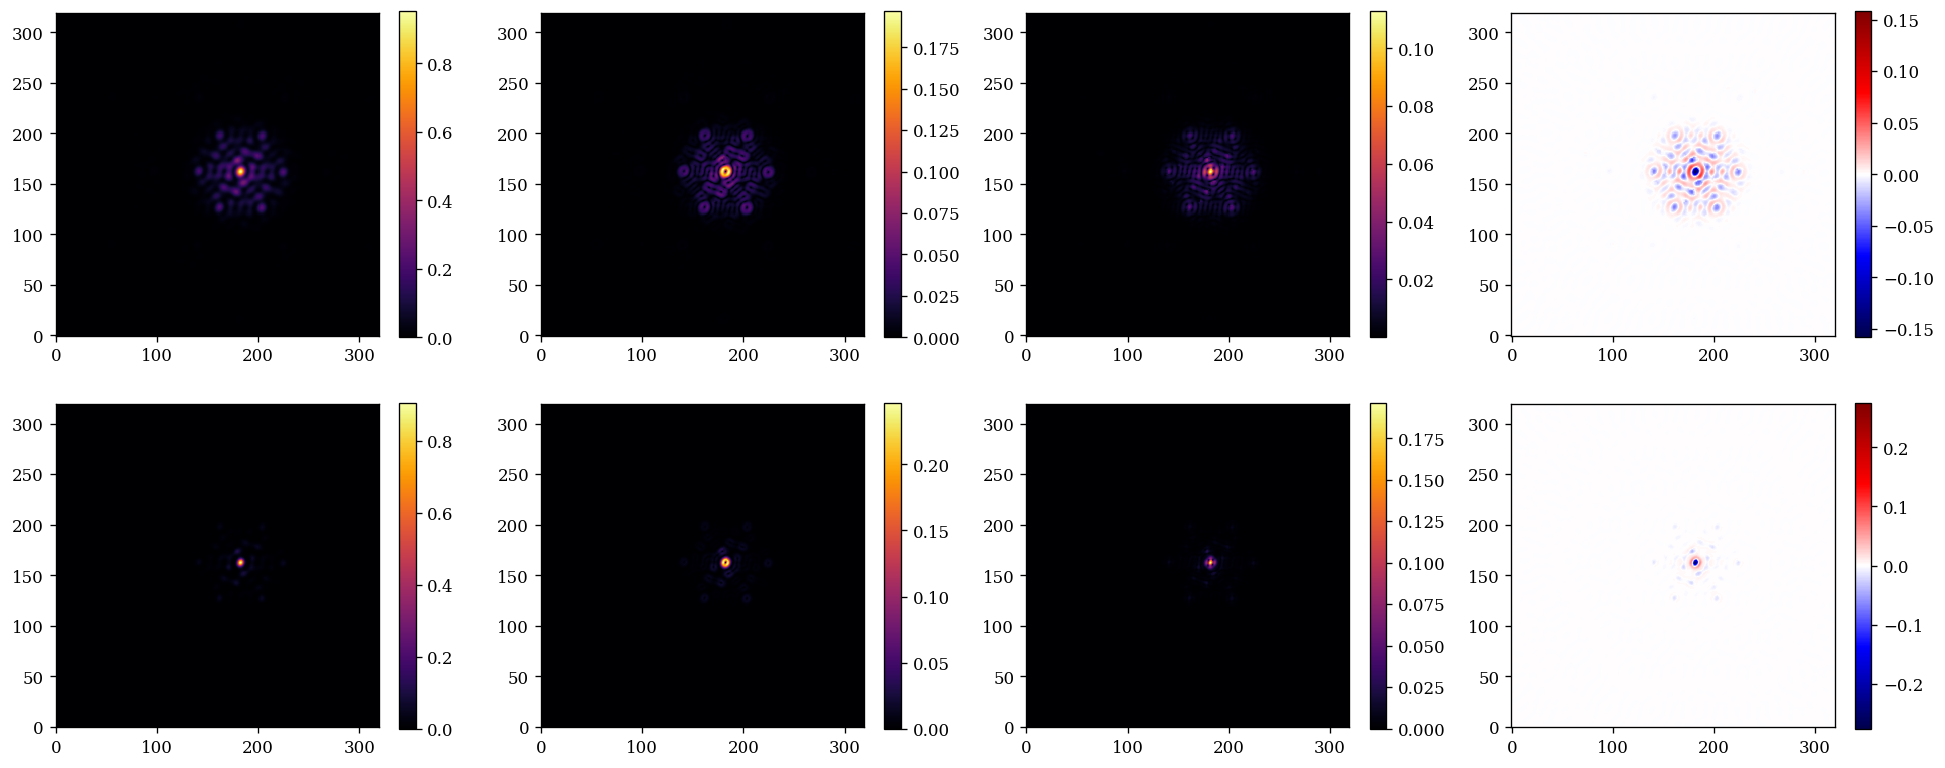

In [7]:
filter_norm = {"F380M": 6.5e4, "F430M": 7.5e4, "F480M": 9e4}

for exp in exposures:

    psf = model.model(exp, to_BFE=True)
    photons = 20 * psf * filter_norm[exp.filter]
    basis = build_basis(photons)

    print(basis.shape)

    ncols = 4
    nrows = len(basis) // ncols + 1

    plt.figure(figsize=(5 * ncols, 4 * nrows))
    for i in range(len(basis)):
        plt.subplot(nrows, ncols, i + 1)
        if i%4 == 3:
            v = np.max(np.abs(basis[i]))
            plt.imshow(basis[i], cmap=seismic, vmin=-v, vmax=v)
        else:
            plt.imshow(basis[i])
        plt.colorbar()
    plt.show()

In [8]:
import jax.random as jr
from amigo.CNN import calc_rfield
import equinox as eqx

key = jr.PRNGKey(0)
subkeys = jr.split(key, 100)
use_bias = True

in_size = len(basis)

in_size = 2 * len(basis)
print(in_size)
# widths = [32, 16, 8, 4]
# widths = [16, 8, 4, 2]
widths = [8, 8, 4, 4]
# widths = [2, 2, 1, 1]

layers = [
    eqx.nn.Conv2d(
        in_channels=in_size,
        out_channels=widths[0],
        use_bias=use_bias,
        padding=1,
        kernel_size=3,
        key=subkeys[0],
    ),
    eqx.nn.Conv2d(
        in_channels=widths[0],
        out_channels=widths[1],
        use_bias=use_bias,
        dilation=(2, 2),
        padding=2,
        kernel_size=3,
        key=subkeys[1],
    ),
    eqx.nn.Conv2d(
        in_channels=widths[1],
        out_channels=widths[2],
        use_bias=use_bias,
        padding=1,
        kernel_size=3,
        key=subkeys[2],
    ),
    eqx.nn.Conv2d(
        in_channels=widths[2],
        out_channels=widths[3],
        use_bias=use_bias,
        dilation=(2, 2),
        padding=2,
        kernel_size=3,
        key=subkeys[3],
    ),
    eqx.nn.Conv2d(
        in_channels=widths[3],
        out_channels=1,
        use_bias=use_bias,
        padding=1,
        kernel_size=3,
        key=subkeys[4],
    ),
]
print(f"Field of Regard: {calc_rfield(layers)}")

x = np.zeros((in_size, 320, 320))

for layer in layers:
    x = layer(x)
print(x.shape)

16
Field of Regard: 21
(1, 320, 320)


In [9]:
import dLux as dl
import dLux.utils as dlu
from jax import vmap
import jax.tree_util as jtu
from amigo.core import NNWrapper


from amigo.detector_layers import Ramp


class ConvEDM(dl.detector_layers.DetectorLayer):
    conv: None
    amplitude: float
    steps = 20
    flux: float
    ngroups: int
    filter: str
    filter_norm: dict = eqx.field(static=True)

    def __init__(self, layers, amplitude=1e0, flux=1.0, ngroups=2, filter='F430M'):
        def zero_bias(layer):
            return eqx.tree_at(lambda x: x.bias, layer, np.zeros_like(layer.bias))
        layers = [zero_bias(layer) for layer in layers]

        self.conv = NNWrapper(layers)
        self.amplitude = np.array(amplitude)
        self.flux = np.array(flux, float)
        self.ngroups = int(ngroups)
        self.filter = filter

        self.filter_norm = {
            "F380M": 6.5e4,
            "F430M": 7.5e4,
            "F480M": 9e4,
        }

    def apply(self, psf):
        ramp = self.sample_ramp(self.bleeding_model(psf.data)[0])
        dsample_fn = lambda x: dlu.downsample(x, 4, mean=False)
        return Ramp(vmap(dsample_fn)(ramp), psf.pixel_scale)

    def bleeding_model(self, psf):

        photons = psf * self.filter_norm[self.filter]
        # photons = self.get_photons(psf)
        charge, bleed = np.zeros(psf.shape), np.zeros(psf.shape)

        ramp, bleed_ramp = [], []
        for i in range(self.steps):

            # Build basis
            basis = np.concatenate(
                [
                    build_basis(charge),
                    build_basis(photons),
                    # build_basis(bleeding),
                ],
                0,
            )

            # Scale bleeding by amplitude
            bleeding = self.amplitude * np.squeeze(self.conv(basis))

            # TODO: We COULD make the bleeding a polynomial function of the current step
            # Since the bleeding is positive and negative, we need to use the `safe_pow`
            # function used in the basis creation

            # TODO: The incoming photons could also be a function of the current step
            # This might be an easier way to do pixel non-linearities

            charge += photons + bleeding
            # charge += photons
            bleed += bleeding

            ramp.append(charge)
            bleed_ramp.append(bleed)

        return np.array(ramp), np.array(bleed_ramp)

    def sample_ramp(self, ramp):

        photons_in = self.filter_norm[self.filter] * self.steps

        # Pre-pend a zeroth group to allow interpolation for low values
        ramp = np.concatenate([np.zeros((1, *ramp.shape[1:])), ramp], axis=0)

        # Generate the coordinates up the ramp
        flux_coords = photons_in * np.arange(self.steps + 1) / self.steps
        group_coords = self.flux * (np.arange(self.ngroups) + 1) / self.ngroups

        # Check for fluxes exceeding the total flux
        _ = jax.lax.cond(
            group_coords[-1] > flux_coords[-1],
            lambda _: jax.debug.print("Warning: Group fluxes exceed the total flux"),
            lambda _: None,
            None,
        )

        # Interpolate the ramp
        ramp_fn = vmap(lambda fp: np.interp(group_coords, flux_coords, fp), 1, 1)
        ramp_out = ramp_fn(np.array(ramp).reshape(len(ramp), -1))
        return ramp_out.reshape(self.ngroups, *ramp[0].shape)


EDM = ConvEDM(layers)

model = model.set("EDM", EDM)

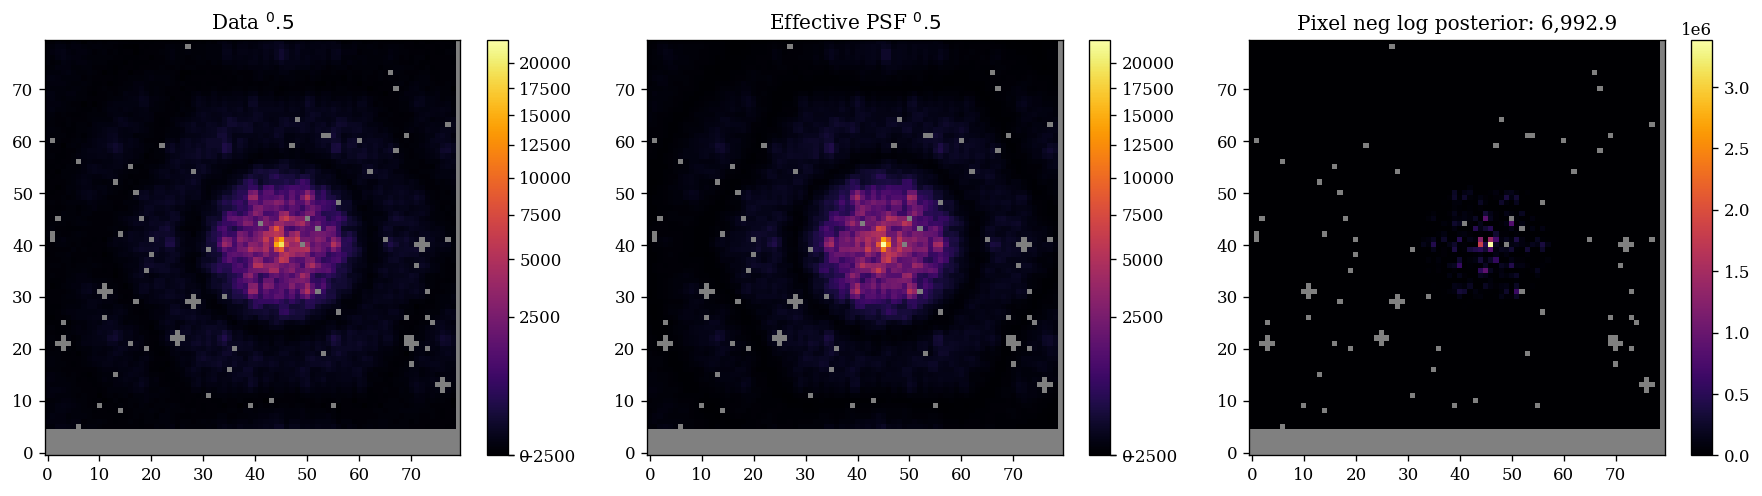

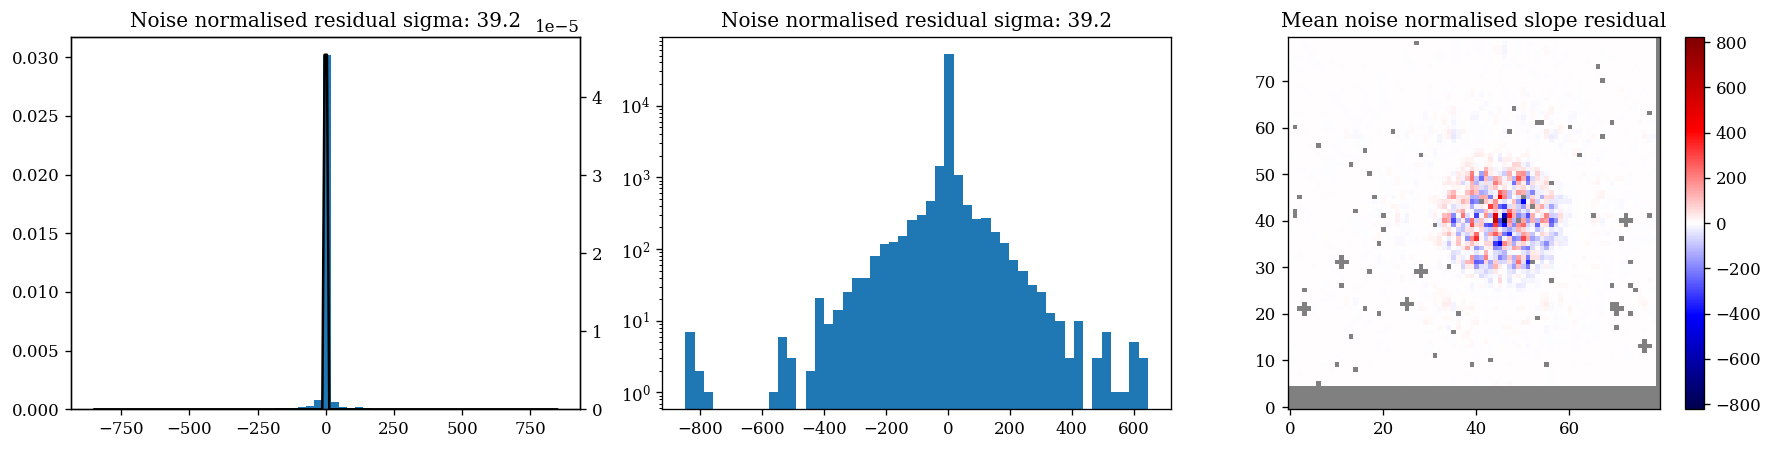

In [10]:
for exp in exposures:
    exp.summarise_fit(model, residuals=True, histograms=True)

In [11]:
from amigo.detector_layers import NullEDM
# from amigo.BFE import DummyBFE

# model = model.set("BFE", DummyBFE())
model = model.set("EDM", NullEDM())

In [12]:
from tqdm.notebook import tqdm
from amigo.step_mappers import LocalStepMapper, MaskStepMapper
# from amigo.step_mappers import MaskStepMapper

# Calculate local step matrices
local_mappers = []
for exp in tqdm(exposures):
    local_mappers.append(LocalStepMapper(model, exp))

  0%|          | 0/1 [00:00<?, ?it/s]

2024-06-04 23:33:53.503833: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce-window = f64[9,32,32]{2,1,0} reduce-window(f64[9,1024,1024]{2,1,0} %constant.2533, f64[] %constant.135), window={size=1x32x32 stride=1x32x32}, to_apply=%region_2.156

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-06-04 23:33:53.574102: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.077492s
Constant folding an instruction is taking > 1s:

  %reduce-window = f64[9,32,32]{2,1,0} reduce-window(f64[9,1024,1024]{2,1,0} %constant.2533, f64[] %constant.135), window={size=1

Main Time: 76.68
Noise Time: 7.50


In [15]:
# def calculate_mask_fisher(
#     model,
#     exposure,
#     self_fisher=True,
#     # photon=False,
#     per_pix=False,
#     read_noise=10.0,
#     true_read_noise=False,
#     **kwargs,
# ):

#     fisher_fn = lambda *args, **kwargs: get_fisher(
#         *args,
#         model,
#         exposure,
#         self_fisher=self_fisher,
#         # photon=photon,
#         per_pix=per_pix,
#         read_noise=read_noise,
#         true_read_noise=true_read_noise,
#         **kwargs,
#     )
#     global_params = [
#         "holes",
#         "f2f",
#         "translation",
#         "compression",
#         "rotation",
#         "shear",
#     ]

#     # N = np.array(jtu.tree_map(lambda x: x.size, model.get(global_params))).sum()

#     # Holes ~1.5 minutes
#     t0 = time.time()
#     fisher_mask = fisher_fn(params=global_params, **kwargs)
#     # mask = np.zeros((N, N))
#     N = len(fisher_mask)
#     mask = np.ones((N, N))
#     mask = mask.at[:14, :14].set(np.eye(14))
#     # mask = mask.at[14:, 14:].set(1.0)
#     fisher_mask *= mask
#     print(f"Mask Time: {time.time() - t0:.2f}")

#     return fisher_mask


# class MaskStepMapper(MatrixMapper):
#     fisher_matrix: jax.Array

#     def __init__(self, model, exposures, **kwargs):

#         self.step_type = "matrix"
#         self.params = [
#             "holes",
#             "f2f",
#             "translation",
#             "compression",
#             "rotation",
#             "shear",
#         ]

#         fisher_matrices = []
#         for exp in tqdm(exposures):
#             fisher_matrices.append(
#                 calculate_mask_fisher(
#                     model, exp, self_fisher=True, per_pix=True, **kwargs
#                 )
#             )

#         self.fisher_matrix = np.array(fisher_matrices)
#         self.step_matrix = -np.linalg.inv(self.fisher_matrix.sum(0))

#     def recalculate(self, model, exposures):
#         fisher_matrices = []
#         for exp in tqdm(exposures):
#             fisher_matrices.append(
#                 calculate_mask_fisher(model, exp, self_fisher=True, per_pix=True)
#             )

#         fisher_matrix = np.array(fisher_matrices)
#         step_matrix = -np.linalg.inv(fisher_matrix.sum(0))
#         return self.set(["fisher_matrix", "step_matrix"], [fisher_matrix, step_matrix])

In [17]:
# Calculate global step matrices
mask_mapper = MaskStepMapper(model, exposures)

  0%|          | 0/1 [00:00<?, ?it/s]

2024-06-04 23:35:24.344473: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 2s:

  %reduce.1584 = f64[7,1024,1024]{2,1,0} reduce(f64[7,6,1024,1024]{3,2,1,0} %broadcast.55, f64[] %constant.48), dimensions={1}, to_apply=%region_53.1580, metadata={op_name="jit(<unnamed wrapped function>)/jit(main)/reduce_sum[axes=(1,)]" source_file="/var/folders/28/6s47s91d14ldjdrljs4d1hxw0000gn/T/ipykernel_12217/2511451613.py" source_line=2}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-06-04 23:35:42.828796: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 20.48769s
Constant

Mask Time: 105.28


In [41]:
# plt.hist(np.diag(mask_mapper.step_matrix)[:200], bins=20)
# print(np.diag(mask_mapper.step_matrix)[:100])

fmats = mask_mapper.fisher_matrix
fmats = fmats * np.eye(fmats.shape[-1])[None, :, :]
step_matrix = -np.linalg.inv(fmats.sum(0))
mask_mapper = mask_mapper.set("step_matrix", step_matrix)
# for i in range(len(fmats)):
# print(np.diag(fmats[i]))
# plt.imshow(mask_mapper.step_matrix **0.5)
# plt.colorbar()
# plt.show()

In [24]:
# from amigo.step_mappers import ReflectivityStepMapper

# reflectivity_mapper = ReflectivityStepMapper(model, exposures)

In [25]:
# bfe_mapper = BFEStepMapper(model, exposures)

In [26]:
# from amigo.step_mappers import SRFStepMapper

# SRF_mapper = SRFStepMapper(model, exposures)

In [27]:
model.dark_current

Array(0., dtype=float64)

In [28]:
# from amigo.step_mappers import DarkCurrentStepMapper, get_fisher, MatrixMapper
# import time

# def calculate_dark_current_fisher(
#     model,
#     exposure,
#     self_fisher=True,
#     # photon=False,
#     per_pix=False,
#     read_noise=10.0,
#     true_read_noise=False,
# ):

#     fisher_fn = lambda *args, **kwargs: get_fisher(
#         *args,
#         model,
#         exposure,
#         self_fisher=self_fisher,
#         # photon=photon,
#         per_pix=per_pix,
#         read_noise=read_noise,
#         true_read_noise=true_read_noise,
#         **kwargs,
#     )
#     # Holes ~1.5 minutes
#     t0 = time.time()
#     fisher_reflectivity = fisher_fn(params=["dark_current"])
#     print(f"Dark current Time: {time.time() - t0:.2f}")

#     return fisher_reflectivity


# class DarkCurrentStepMapper(MatrixMapper):
#     fisher_matrix: jax.Array

#     def __init__(self, model, exposures):

#         self.step_type = "matrix"
#         self.params = ["dark_current"]

#         fisher_matrices = []
#         for exp in tqdm(exposures):
#             fisher_matrices.append(
#                 calculate_dark_current_fisher(
#                     model, exp, self_fisher=True, per_pix=True
#                 )
#             )

#         self.fisher_matrix = np.array(fisher_matrices)
#         self.step_matrix = -np.linalg.inv(self.fisher_matrix.sum(0))

#     def recalculate(self, model, exposures):
#         fisher_matrices = []
#         for exp in tqdm(exposures):
#             fisher_matrices.append(
#                 calculate_dark_current_fisher(
#                     model, exp, self_fisher=True, per_pix=True
#                 )
#             )

#         fisher_matrix = np.array(fisher_matrices)
#         step_matrix = -np.linalg.inv(fisher_matrix.sum(0))
#         return self.set(["fisher_matrix", "step_matrix"], [fisher_matrix, step_matrix])

In [29]:
from amigo.step_mappers import DarkCurrentStepMapper
dc_mapper = DarkCurrentStepMapper(model, exposures)

  0%|          | 0/1 [00:00<?, ?it/s]

Dark current Time: 4.81


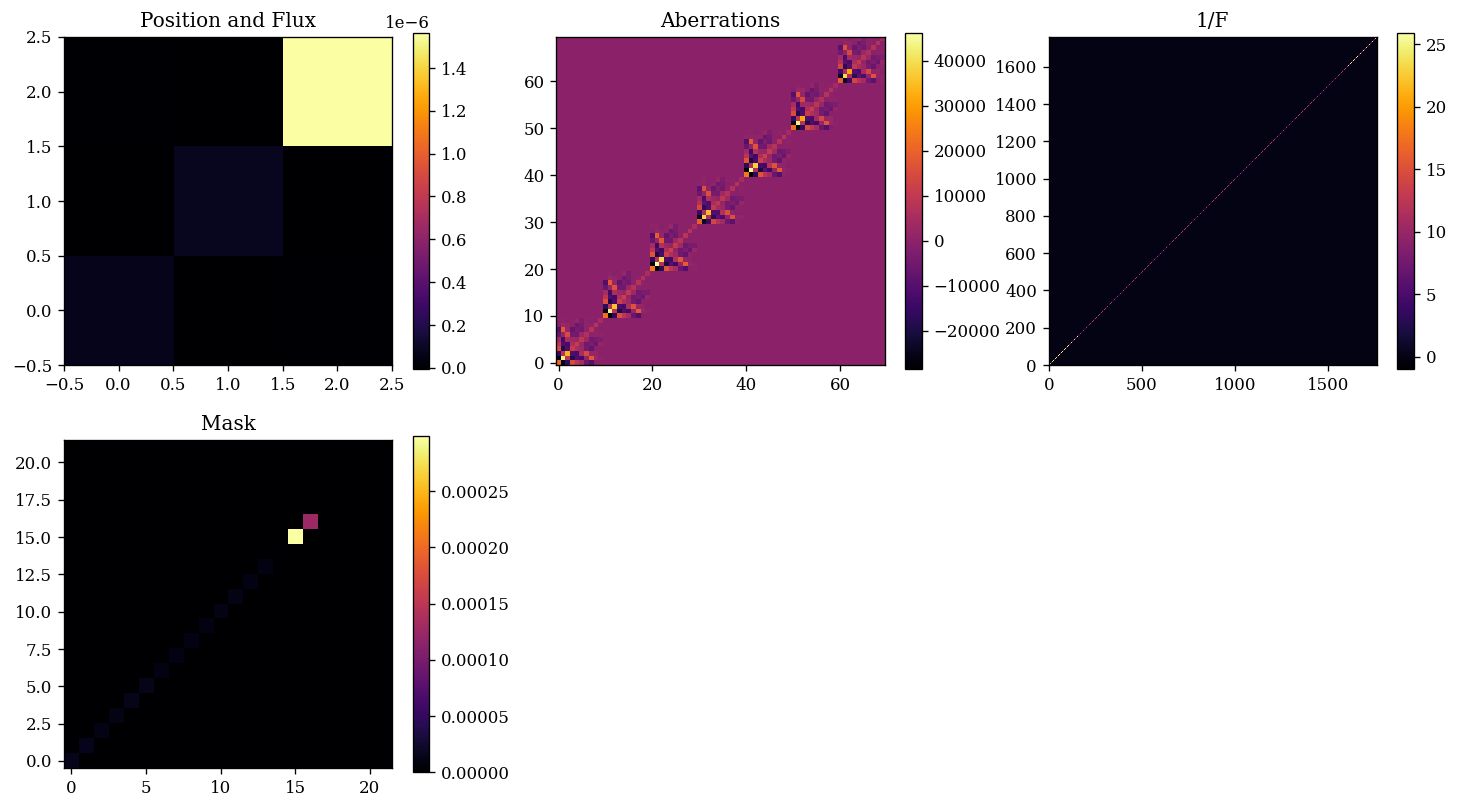

In [42]:
step_mappers = local_mappers + [mask_mapper, dc_mapper]

local_step = local_mappers[0].step_matrix
mask_step_matrix = mask_mapper.step_matrix
# bfe_step_vec = bfe_mapper.step_matrix

# local_step = -np.linalg.inv(local_fisher)
# local_step = -np.linalg.inv(fixed_local_fisher)
nmain = 3
main_step = local_step[:nmain, :nmain]

nabb = optics.pupil.coefficients.size
start = nmain
end = nmain + nabb
aberration_step = local_step[start:end, start:end]

nfs = 80 * 2 * exp.ngroups
one_on_f_step = local_step[-nfs:, -nfs:]

mask_step = mask_step_matrix

plt.figure(figsize=(15, 8))
plt.subplot(2, 3, 1)
plt.title("Position and Flux")
plt.imshow(main_step)
plt.colorbar()

plt.subplot(2, 3, 2)
plt.title("Aberrations")
plt.imshow(aberration_step)
plt.colorbar()

plt.subplot(2, 3, 3)
plt.title("1/F")
plt.imshow(one_on_f_step)
plt.colorbar()

plt.subplot(2, 3, 4)
plt.title("Mask")
plt.imshow(mask_step)
plt.colorbar()

# plt.subplot(2, 3, 5)
# plt.title("Pixel Anisotropy")
# plt.imshow(aniso_mapper.step_matrix)
# plt.colorbar()

# plt.subplot(2, 3, 5)
# plt.title("SRF")
# v = np.abs(bfe_step_vec).max()
# plt.imshow(bfe_mapper.step_matrix, cmap="seismic", vmin=-v, vmax=v)
# plt.imshow(SRF_mapper.step_matrix)
# plt.colorbar()

# n_linear = 25 ** 2
# n_linear = 12 ** 2
# plt.subplot(2, 3, 5)
# plt.title("BFE Linear")
# plt.hist(bfe_step_vec[:n_linear], bins=50)

# plt.subplot(2, 3, 6)
# # plt.title("BFE Quadratic")
# plt.title("BFE Quadratic & Cubic")
# plt.hist(bfe_step_vec[n_linear:], bins=50)

# plt.subplot(2, 3, 6)
# plt.title("BFE")
# v = np.abs(bfe_step_vec).max()
# plt.imshow(bfe_mapper.step_matrix, cmap="seismic", vmin=-v, vmax=v)
# plt.imshow(bfe_mapper.step_matrix)
# plt.colorbar()


plt.show()

In [43]:
norm_shift = lambda pos: pos - pos.mean(0)
compression_norm = lambda pos: pos / np.abs(pos).mean(0)


def rotation_norm(pos):
    polar = vmap(dlu.cart2polar)(pos_grads)
    rs, phis = polar[:, 0], polar[:, 1]
    phis -= phis.mean(0)
    return vmap(dlu.polar2cart)(np.array([rs, phis]).T)


# def shear_norm(pos):
#     xs, ys = pos.T
#     xs -= xs.mean()
#     ys -= ys.mean()
#     return np.array([xs, ys]).T

def norm_holes(grads):
    hole_grads = rotation_norm(grads.holes)
    hole_grads = compression_norm(hole_grads)
    return grads.set('holes', norm_shift(hole_grads))


def grad_fn(model, grads, args):
    grads = norm_holes(grads)

    # for key, value in mappers.items():
    #     grads = grads.multiply(key, value)
    # return grads
    # jax.debug.print()
    # jax.debug.print(f"{param}: " + "{y}", y=grads.get(param))
    # Nan function goes here if wanted
    step_mappers = args['step_mappers']
    for step_mapper in step_mappers:
        # print(grads.get(step_mapper.params))
        grads = step_mapper.apply(grads)
    return grads


def norm_fn(model_params, args):
    # print("inside model norm")
    return model_params
    p = 0.00005
    # p = 0.
    keys = jr.split(args['key'], 2)
    #
    conv_weight_map = jr.uniform(keys[0], model_params.BFE.conv.weights.shape)
    conv_bias_map = jr.uniform(keys[1], model_params.BFE.conv.biases.shape)
    conv_new_weight = np.where(conv_weight_map > p, model_params.BFE.conv.weights, 0)
    conv_new_bias = np.where(conv_bias_map > p, model_params.BFE.conv.biases, 0)
    #
    model_params = model_params.set(
        ["BFE.conv.weights", "BFE.conv.biases"],
        [conv_new_weight, conv_new_bias],
    ) 
    return model_params
    # reflect = model_params.holes.reflectivity
    # return model_params.set("holes.reflectivity", reflect - reflect.mean())
    # SRF = model_params.sensitivity.SRF
    # return model_params.set("sensitivity.SRF", SRF - SRF.mean() + 1)

In [45]:
def args_fn(model, args):
    # exposures, step_mappers, key = args
    args['key'] = jr.split(args['key'], 1)[0]

    # return model, (exposures, new_mappers, jr.split(key, 1)[0])
    # return model, (exposures, step_mappers, jr.split(key, 1)[0])
    return model, args

In [66]:
import optax
from amigo.fitting import optimise

clip = lambda optimiser, v: optax.chain(optimiser, optax.clip(v))

def scheduler(lr, start, *args):
    shed_dict = {start: 1e100}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e100, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)
base_adam = lambda vals: optax.adam(vals)

sgd = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))
adam = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


batch_size = 1
nbatch = len(exposures) // batch_size
if len(exposures) % batch_size != 0:
    nbatch += 1
optimisers = {
    "positions": sgd(5e-1, 0),
    "aberrations": sgd(2e-1, 5),
    "fluxes": sgd(2e-1, 10),
    "one_on_fs": sgd(0, 10),
    "shear": sgd(2e-1, 15),
    "rotation": sgd(2e-1, 15),
    "compression": sgd(2e-1, 15),
    "translation": sgd(1e-1, 15),
    "f2f": sgd(1e-1, 15),
    # Coherence
    "dark_current": sgd(2e-1, 20),
    "jitter.r": sgd(5e-17, 20),
    # "holes": sgd(2e-1, 25),
    "holes": sgd(2e0, 25),
    "EDM.conv.values": adam(1e-2, 20 * nbatch),
    "EDM.amplitude": adam(1e-1, 20 * nbatch),
}

args = {
    "exposures": exposures,
    "step_mappers": step_mappers,
    "key": jr.PRNGKey(0),
    
}

model = model.set("EDM", EDM)


# Optimisation
final_model, losses, histories, states = optimise(
    model,
    args,
    50,
    optimisers,
    batch_size=batch_size,
    grad_fn=grad_fn,
    norm_fn=norm_fn,
    args_fn=args_fn,
    print_grads=False,
    batch_params = ["EDM.conv.values", "EDM.amplitude"],
)

  0%|          | 0/50 [00:00<?, ?it/s]

Grad Batch fn compiling...
Compiling update function
Compiling update function
Full Time: 0:05:40
Final Loss: 51.15


In [67]:
from amigo.core import AmigoHistory

class NewHistory(AmigoHistory):
    def __init__(self, params):
        self.params = params

    def _plot_param(self, ax, arr, param, start=0, end=-1, **kwargs):
        """This is the ugly gross function that is necessary"""
        # print(start, end)
        arr = arr[start:end]
        epochs = np.arange(len(arr))
        ax.set(xlabel="Epochs", title=param)  # , xlim=(start, epochs[end]))

        match param:
            case "positions":
                norm_pos = arr - arr[0]
                # rs = np.hypot(norm_pos[:, 0], norm_pos[:, 1])
                # ax.plot(epochs, rs, **kwargs)
                ax.plot(epochs, norm_pos, **kwargs)
                ax.set(ylabel="$\Delta$ Position (arcsec)")

            case "fluxes":
                norm_flux = arr - arr[0]
                # norm_flux = 100 * (1 - arr / arr[0])
                ax.plot(epochs, norm_flux, **kwargs)
                ax.set(ylabel="$\Delta$ Flux (log)")

            case "aberrations":
                norm_ab = arr - arr[0]
                ax.plot(epochs, norm_ab, alpha=0.4, **kwargs)
                ax.set(ylabel="$\Delta$ Aberrations (nm)")

            case "one_on_fs":
                norm_oneonf = arr - arr[0]
                ax.plot(epochs, norm_oneonf, alpha=0.25, **kwargs)
                ax.set(ylabel="$\Delta$ one_on_fs")

            case "BFE":
                pass
                # norm_bfe_lin = arr - arr[0]
                # ax.plot(epochs, norm_bfe_lin, alpha=0.2, **kwargs)
                # ax.set(ylabel="$\Delta$ Linear Coefficients")

            case "BFE.linear":
                norm_bfe_lin = arr - arr[0]
                ax.plot(epochs, norm_bfe_lin, alpha=0.2, **kwargs)
                ax.set(ylabel="$\Delta$ Linear Coefficients")

            case "BFE.quadratic":
                norm_bfe_quad = arr - arr[0]
                ax.plot(epochs, norm_bfe_quad, alpha=0.1, **kwargs)
                ax.set(ylabel="$\Delta$ BFE Quadratic Coefficients")

            case "BFE.coeffs":
                norm_bfe = arr - arr[0]
                ax.plot(epochs, norm_bfe, alpha=0.5, **kwargs)
                ax.set(ylabel="$\Delta$ Linear Coefficients")

            case "SRF":
                srf = arr - arr[0]
                ax.plot(epochs, srf, **kwargs)
                ax.set(ylabel="SRF")

            case "holes":
                arr *= 1e3
                norm_holes = arr - arr[0]
                ax.plot(epochs, norm_holes, **kwargs)
                ax.set(ylabel="$\Delta$ Pupil Mask Holes (mm)")

            case "f2f":
                arr *= 1e2
                ax.plot(epochs, arr, **kwargs)
                ax.set(ylabel="Pupil Mask f2f (cm)")

            case "biases":
                norm_bias = arr - arr[0]
                ax.plot(epochs, norm_bias, alpha=0.25, **kwargs)
                ax.set(ylabel="$\Delta$ Bias")

            case "rotation":
                arr = dlu.rad2deg(arr)
                norm_rot = arr
                ax.plot(epochs, norm_rot, **kwargs)
                ax.set(ylabel="Rotation (deg)")

            case "compression":
                ax.plot(epochs, arr, **kwargs)
                ax.set(ylabel="Compression (deg)")

            case "translation":
                arr *= 1e2
                ax.plot(epochs, arr, **kwargs)
                ax.set(ylabel="translation (cm)")

            case "amplitudes":
                norm_amplitudes = arr
                ax.plot(epochs, norm_amplitudes, **kwargs)
                ax.set(ylabel="Visibility Amplitude")

            case "dark_current.dark_current":
                # norm_amplitudes = arr
                ax.plot(epochs, arr, **kwargs)
                ax.set(ylabel="Dark Current")

            case "phases":
                arr = dlu.rad2deg(arr)
                norm_phases = arr
                ax.plot(epochs, norm_phases, **kwargs)
                ax.set(ylabel="Visibility Phase (deg)")

            case "EDM.conv.values":
                norm_weights = arr - arr[0]
                ax.plot(epochs, norm_weights, **kwargs)
                ax.set(ylabel="$\Delta$ Convolutional Values")

            # case "BFE.conv.biases":
            #     norm_biases = arr - arr[0]
            #     ax.plot(epochs, norm_biases, **kwargs)
            #     ax.set(ylabel="$\Delta$ Convolutional Biases")

            # case "BFE.dense.weights":
            #     norm_weights = arr - arr[0]
            #     ax.plot(epochs, norm_weights, **kwargs)
            #     ax.set(ylabel="$\Delta$ Dense Weights")

            # case "BFE.dense.biases":
            #     norm_biases = arr - arr[0]
            #     ax.plot(epochs, norm_biases, **kwargs)
            #     ax.set(ylabel="$\Delta$ Dense Biases")

            case _:
                print(f"No formatting function for {param}")
                ax.plot(epochs, arr - arr[0], **kwargs)
                ax.set(ylabel="$\Delta$ values")

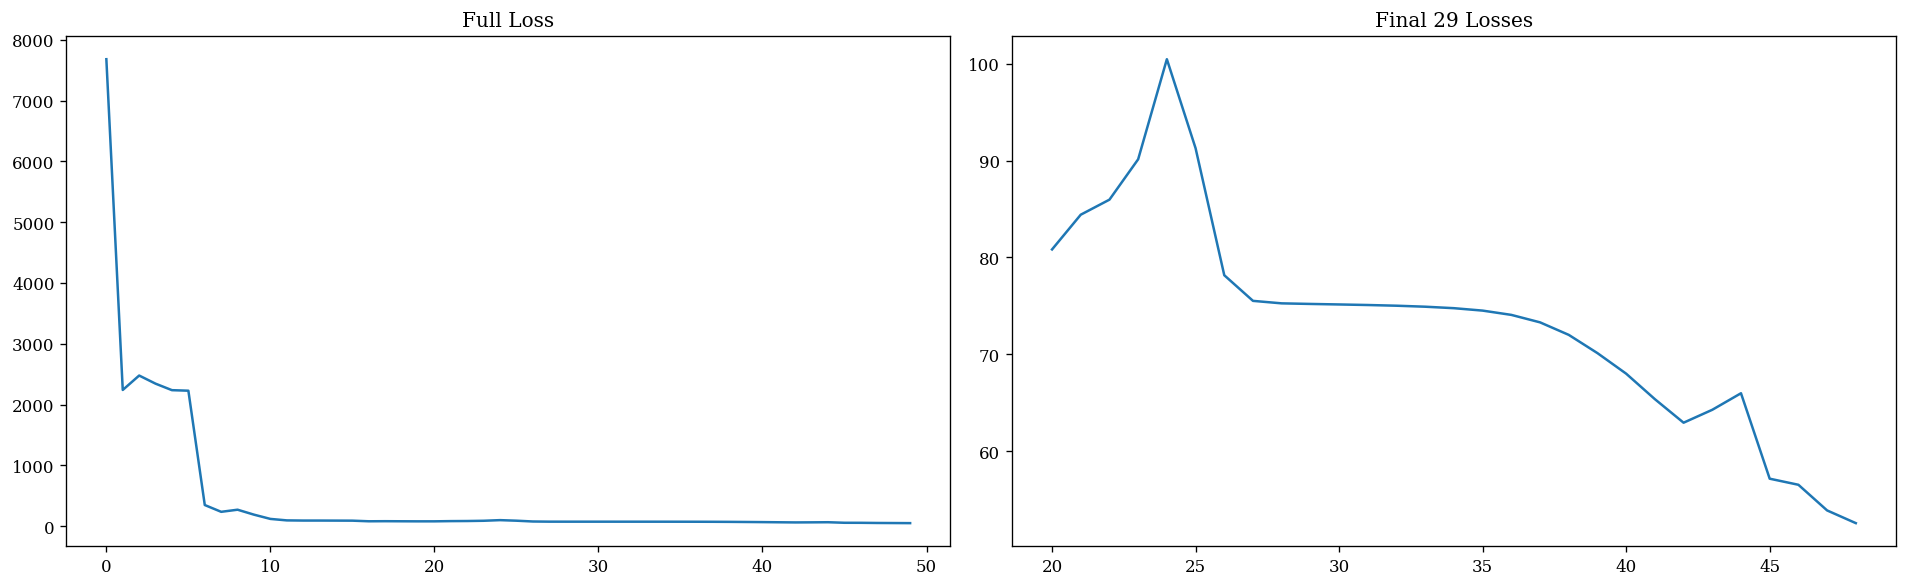

NEW


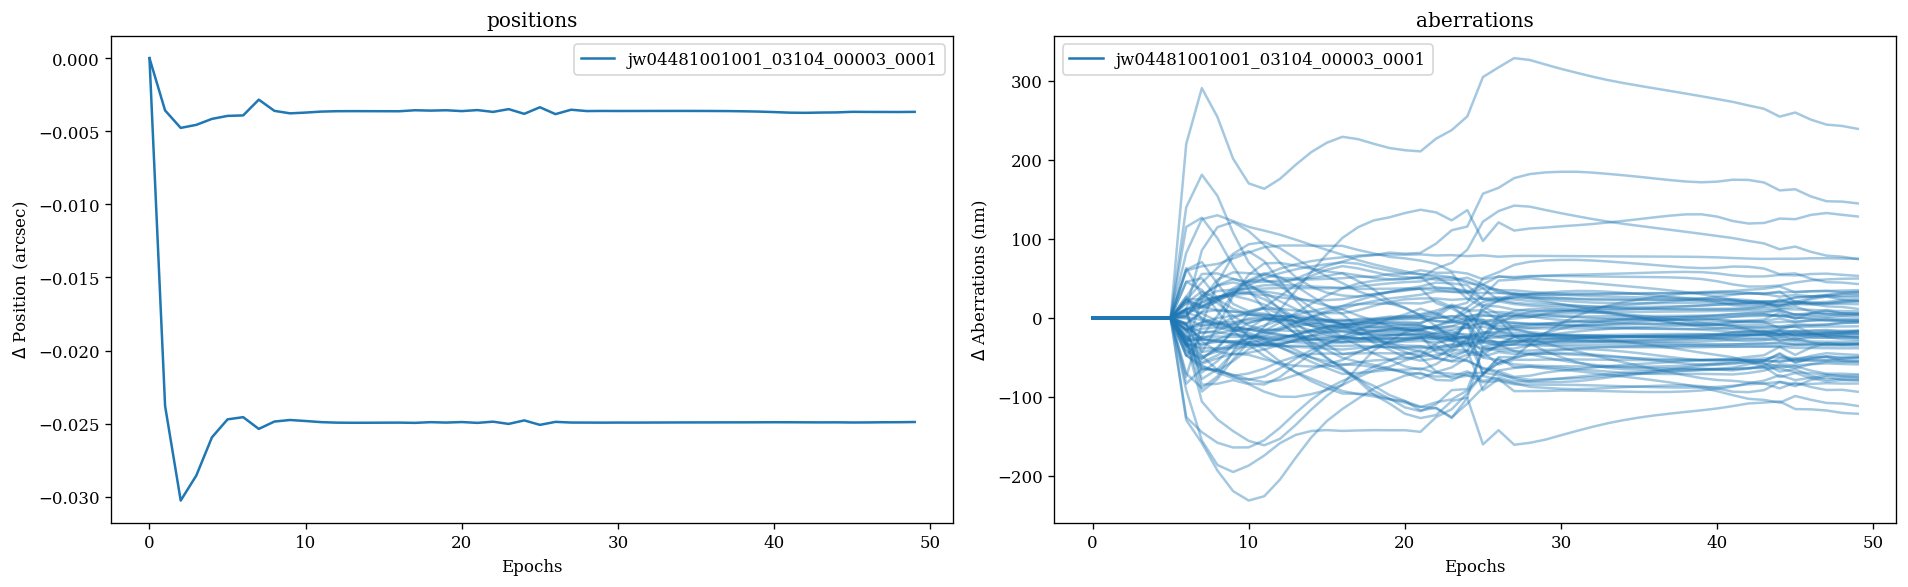

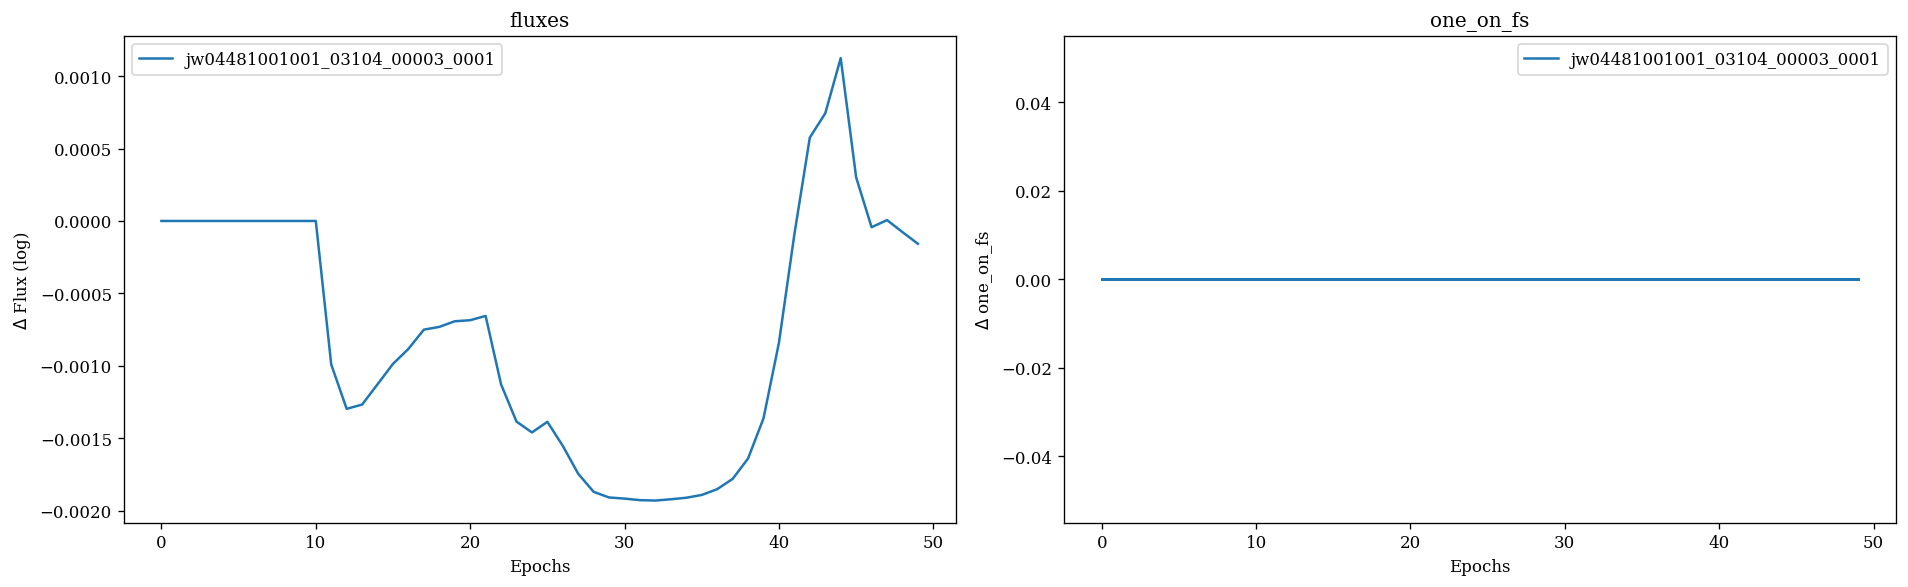

No formatting function for shear


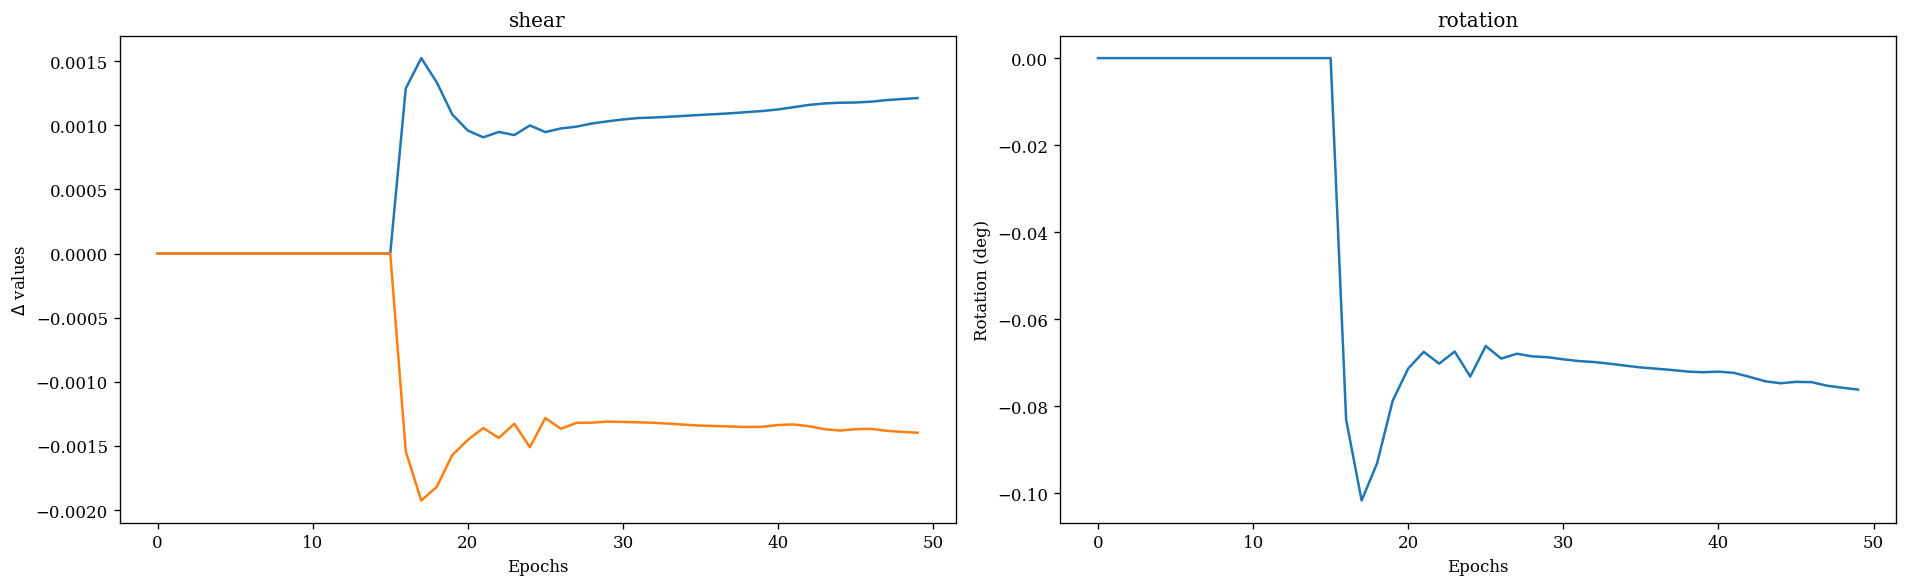

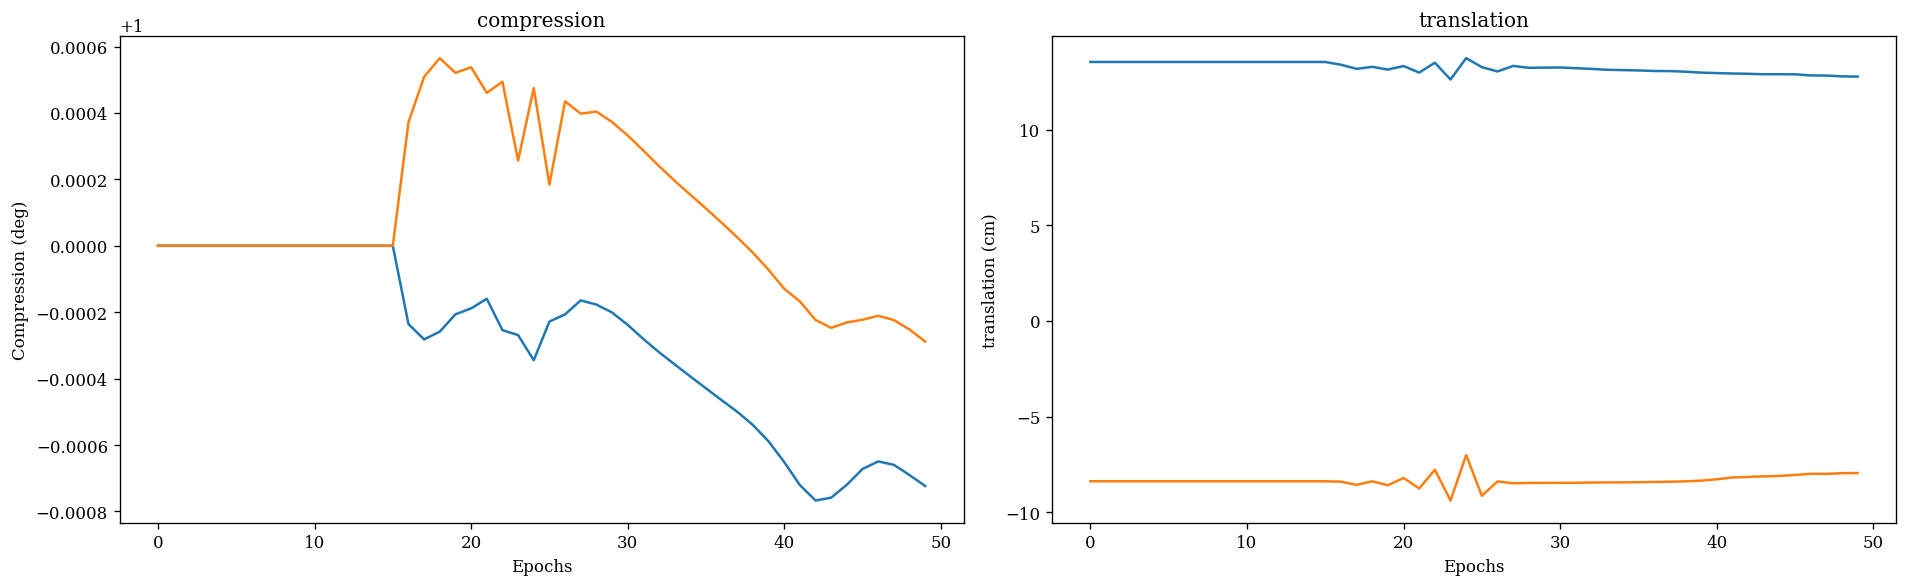

No formatting function for dark_current


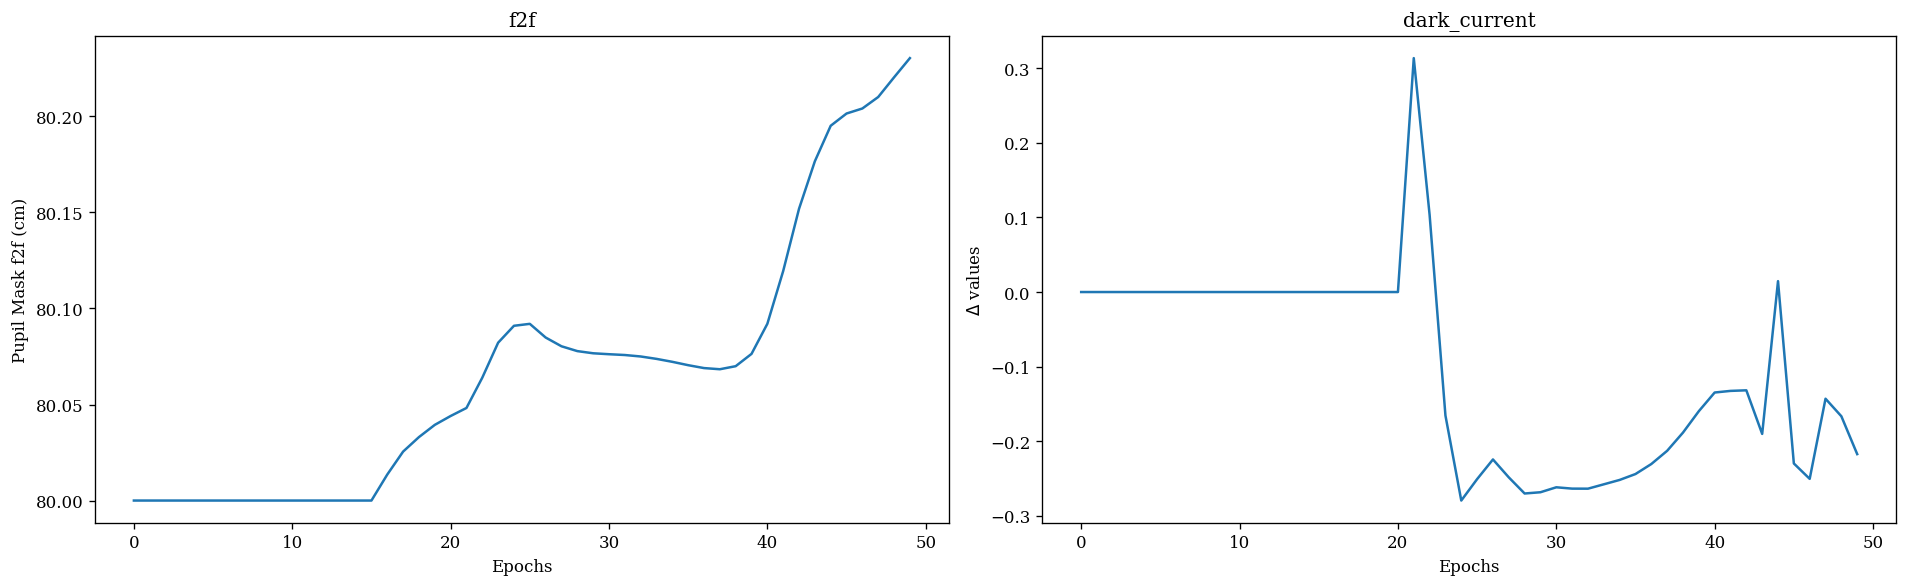

No formatting function for jitter.r


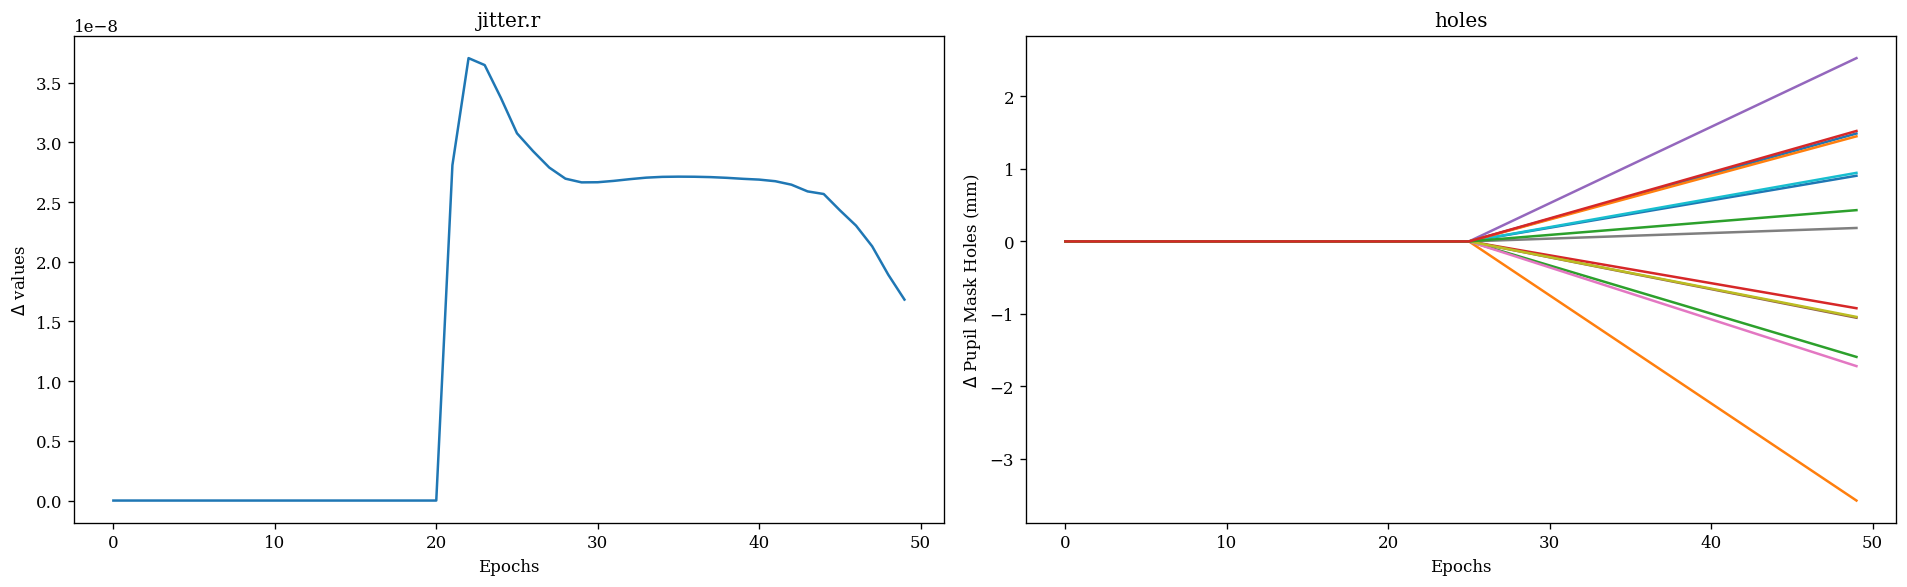

NEW
No formatting function for EDM.amplitude


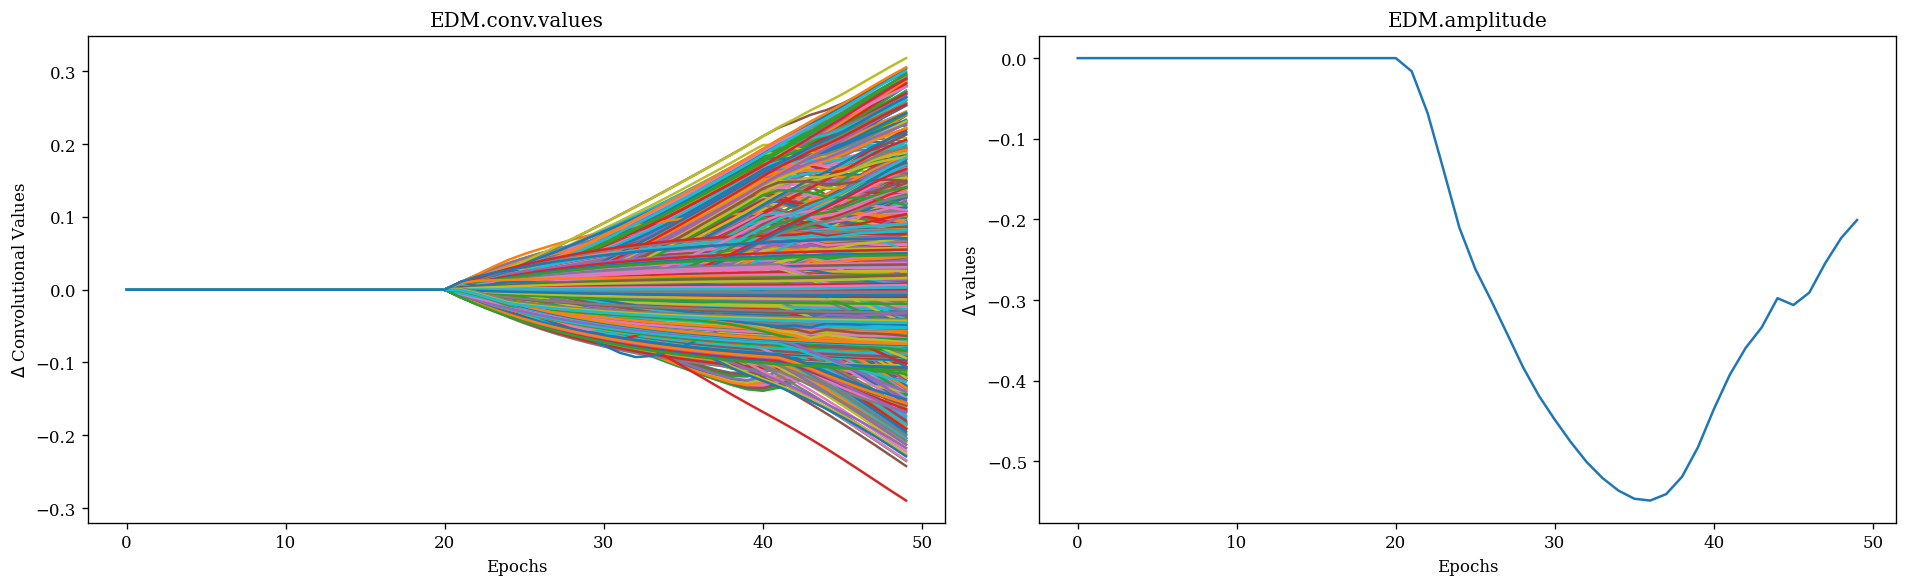

In [68]:
from amigo.plotting import plot_losses


key_fn = lambda exp: f"{exp.ngroups:<3} {exp.nints} {np.nanmean(exp.data[-1]):<5.0f}"

plot_losses(losses, start=20)

for history in histories:
    # print(history)
    print("NEW")

    history = NewHistory(history.params) #, list(history.params.keys()))
    history.plot() #, start=10)

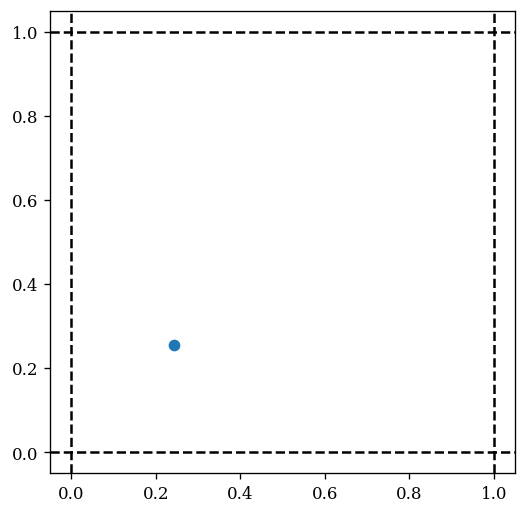

In [69]:
import jax.tree_util as jtu

pos = np.array(
    jtu.tree_leaves(
        jtu.tree_map(lambda x: (x / optics.psf_pixel_scale) % 1, final_model.positions)
    )
)

plt.figure(figsize=(5, 5))
plt.scatter(pos[:, 0], pos[:, 1])
plt.axhline(0, color="k", linestyle="--")
plt.axvline(0, color="k", linestyle="--")
plt.axhline(1, color="k", linestyle="--")
plt.axvline(1, color="k", linestyle="--")

In [70]:
# from amigo.core import Exposure
# from amigo.stats import posterior
# import jax.scipy as jsp

# class NewExposure(Exposure):

#     def __init__(self, exposure):
#         self.data = exposure.data
#         self.variance = exposure.variance
#         self.support = exposure.support
#         self.opd = exposure.opd
#         self.key = exposure.key
#         self.nints = exposure.nints
#         self.ngroups = exposure.ngroups
#         self.nslopes = exposure.nslopes
#         self.filter = exposure.filter
#         self.star = exposure.star
#         self.zero_point = exposure.zero_point


#     def summarise_fit(
#         self,
#         model,
#         # model_fn,
#         residuals=False,
#         histograms=False,
#         flat_field=False,
#         up_the_ramp=False,
#         up_the_ramp_norm=False,
#         full_bias=False,
#         aberrations=False,
#         pow=0.5,
#     ):

#         inferno = colormaps["inferno"]
#         seismic = colormaps["seismic"]

#         # for exp in exposures:
#         # self.print_summary()

#         slopes = model_fn(model, self)
#         data = self.data

#         residual = data - slopes
#         # loglike_im = self.loglike_im(slope)

#         posterior_im = posterior(model, self, return_im=True)

#         # loglike_im = self.log_likelihood(slopes, return_im=True)

#         nan_mask = np.where(np.isnan(posterior_im))
#         slopes = slopes.at[:, *nan_mask].set(np.nan)
#         data = data.at[:, *nan_mask].set(np.nan)

#         final_loss = np.nansum(-posterior_im) / np.prod(np.array(data.shape[-2:]))

#         norm_res_slope = residual / (self.variance**0.5)
#         norm_res_slope = norm_res_slope.at[:, *nan_mask].set(np.nan)

#         norm_res_vec = self.to_vec(norm_res_slope)
#         norm_res_vec = norm_res_vec[~np.isnan(norm_res_vec)]
#         norm_res_vec = norm_res_vec[~np.isinf(norm_res_vec)]

#         x = np.nanmax(np.abs(norm_res_vec))
#         xs = np.linspace(-x, x, 200)
#         ys = jsp.stats.norm.pdf(xs)

#         effective_data = data.sum(0)
#         effective_psf = slopes.sum(0)
#         vmax = np.maximum(np.nanmax(np.abs(effective_data)), np.nanmax(np.abs(effective_psf)))
#         vmin = np.minimum(np.nanmin(np.abs(effective_data)), np.nanmin(np.abs(effective_psf)))

#         skip = False
#         if np.isnan(vmin) or np.isnan(vmax):
#             skip = True

#         if not skip:
#             if residuals:
#                 norm = colors.PowerNorm(gamma=0.5, vmin=-vmin, vmax=vmax)
#                 inferno.set_bad("k", 0.5)
#                 seismic.set_bad("k", 0.5)

#                 plt.figure(figsize=(15, 4))
#                 plt.subplot(1, 3, 1)
#                 plt.title(f"Data $^{str(pow)}$")
#                 plt.imshow(effective_data, cmap=inferno, norm=norm)
#                 plt.colorbar()

#                 plt.subplot(1, 3, 2)
#                 plt.title(f"Effective PSF $^{str(pow)}$")
#                 plt.imshow(effective_psf, cmap=inferno, norm=norm)
#                 plt.colorbar()

#                 plt.subplot(1, 3, 3)
#                 plt.title(f"Pixel neg log posterior: {final_loss:,.1f}")
#                 plt.imshow(-posterior_im, cmap=inferno)
#                 plt.colorbar()

#                 plt.tight_layout()
#                 plt.show()

#             if histograms:

#                 plt.figure(figsize=(15, 4))
#                 ax = plt.subplot(1, 3, 1)
#                 ax.set_title(f"Noise normalised residual sigma: {norm_res_vec.std():.3}")
#                 ax.hist(norm_res_vec.flatten(), bins=50, density=True)

#                 ax2 = ax.twinx()
#                 ax2.plot(xs, ys, c="k")
#                 ax2.set_ylim(0)

#                 ax = plt.subplot(1, 3, 2)
#                 ax.set_title(f"Noise normalised residual sigma: {norm_res_vec.std():.3}")
#                 ax.hist(norm_res_vec.flatten(), bins=50)[0]
#                 ax.semilogy()

#                 # ax2 = ax.twinx()
#                 # ax2.plot(xs, bins.max() * ys, c="k")
#                 # ax2.semilogy()

#                 v = np.nanmax(np.abs(norm_res_slope.mean(0)))
#                 plt.subplot(1, 3, 3)
#                 plt.title("Mean noise normalised slope residual")
#                 plt.imshow(norm_res_slope.mean(0), vmin=-v, vmax=v, cmap=seismic)
#                 plt.colorbar()

#                 plt.tight_layout()
#                 plt.show()

#         if flat_field:
#             plt.figure(figsize=(15, 4))

#             plt.subplot(1, 3, 1)
#             plt.title("Mean Pixel Response Function")
#             v = np.max(np.abs(model.detector.sensitivity.SRF - 1))
#             plt.imshow(model.detector.sensitivity.SRF, vmin=1 - v, vmax=1 + v, cmap=seismic)
#             plt.colorbar()

#             FF = dlu.resize(model.detector.sensitivity.FF, 80)
#             nan_mask = np.where(np.isnan(data.mean(0)))
#             FF = FF.at[nan_mask].set(np.nan)

#             plt.subplot(1, 3, 2)
#             plt.title("Flat Field")
#             plt.imshow(FF, vmin=0, vmax=2, cmap=seismic)
#             plt.colorbar()

#             plt.subplot(1, 3, 3)
#             plt.title("Flat Field Histogram")
#             plt.hist(FF.flatten(), bins=100)
#             # plt.xlim(0, 2)
#             plt.show()

#         if up_the_ramp:
#             ncols = 4
#             nrows = self.nslopes // ncols
#             if self.nslopes % ncols > 0:
#                 nrows += 1

#             plt.figure(figsize=(5 * ncols, 4 * nrows))
#             plt.suptitle("Up The Ramp Residuals")

#             for i in range(self.nslopes):
#                 # plt.subplot(4, 4, i + 1)
#                 plt.subplot(nrows, ncols, i + 1)
#                 v = np.nanmax(np.abs(residual[i]))
#                 plt.imshow(residual[i], cmap=seismic, vmin=-v, vmax=v)
#                 plt.colorbar()
#             plt.show()

#         if up_the_ramp_norm:
#             ncols = 4
#             nrows = self.nslopes // ncols
#             if self.nslopes % ncols > 0:
#                 nrows += 1

#             plt.figure(figsize=(5 * ncols, 4 * nrows))
#             plt.suptitle("Normalised Up The Ramp Residuals")

#             for i in range(self.nslopes):
#                 # plt.subplot(4, 4, i + 1)
#                 plt.subplot(nrows, ncols, i + 1)
#                 v = np.nanmax(np.abs(norm_res_slope[i]))
#                 plt.imshow(norm_res_slope[i], cmap=seismic, vmin=-v, vmax=v)
#                 plt.colorbar()
#             plt.show()

#         if full_bias:
#             coeffs = model.one_on_fs[self.key]
#             nan_mask = 1 + (np.nan * np.isnan(data.sum(0)))
#             bias = nan_mask * model.biases[self.key]

#             plt.figure(figsize=(15, 4))
#             plt.subplot(1, 2, 1)
#             plt.title("Pixel Bias")
#             plt.imshow(bias, cmap=inferno)
#             plt.colorbar()

#             plt.subplot(2, 4, (3, 4))
#             plt.title("1/f Gradient")
#             plt.imshow(coeffs[..., 0])
#             plt.colorbar()
#             plt.xlabel("x-pixel")
#             plt.ylabel("Group")

#             plt.subplot(2, 4, (7, 8))
#             plt.title("1/f Bias")
#             plt.imshow(coeffs[..., 1])
#             plt.colorbar()
#             plt.xlabel("x-pixel")
#             plt.ylabel("Group")

#             plt.tight_layout()
#             plt.show()

#         if aberrations:
#             # Get the AMI mask and applied mask
#             optics = model.optics.set("coefficients", model.aberrations[self.key])
#             # applied_mask = optics.pupil_mask.gen_AMI(optics.wf_npixels, optics.diameter)
#             print(optics)
#             applied_mask = optics.pupil_mask.gen_AMI(optics.wf_npixels, optics.diameter)

#             # Get the applied opds in nm and flip to match the mask
#             static_opd = np.flipud(self.opd) * 1e9
#             added_opd = np.flipud(optics.basis_opd) * 1e9
#             static_opd = static_opd.at[np.where(~(applied_mask > 1e-6))].set(np.nan)
#             added_opd = added_opd.at[np.where(~(applied_mask > 1e-6))].set(np.nan)
#             mirror_opd = static_opd + added_opd

#             plt.figure(figsize=(15, 4))

#             v = np.nanmax(np.abs(static_opd))
#             plt.subplot(1, 3, 1)
#             plt.title("Static OPD")
#             plt.imshow(static_opd, cmap=seismic, vmin=-v, vmax=v)
#             plt.colorbar()

#             v = np.nanmax(np.abs(added_opd))
#             plt.subplot(1, 3, 2)
#             plt.title("Added OPD")
#             plt.imshow(added_opd, cmap=seismic, vmin=-v, vmax=v)
#             plt.colorbar()

#             v = np.nanmax(np.abs(mirror_opd))
#             plt.subplot(1, 3, 3)
#             plt.title("Total OPD")
#             plt.imshow(mirror_opd, cmap=seismic, vmin=-v, vmax=v)
#             plt.colorbar()

#             plt.tight_layout()
#             plt.show()



File jw04481001001_03104_00003_0001
Star HD-41094
Filter F380M
nints 1060
ngroups 11



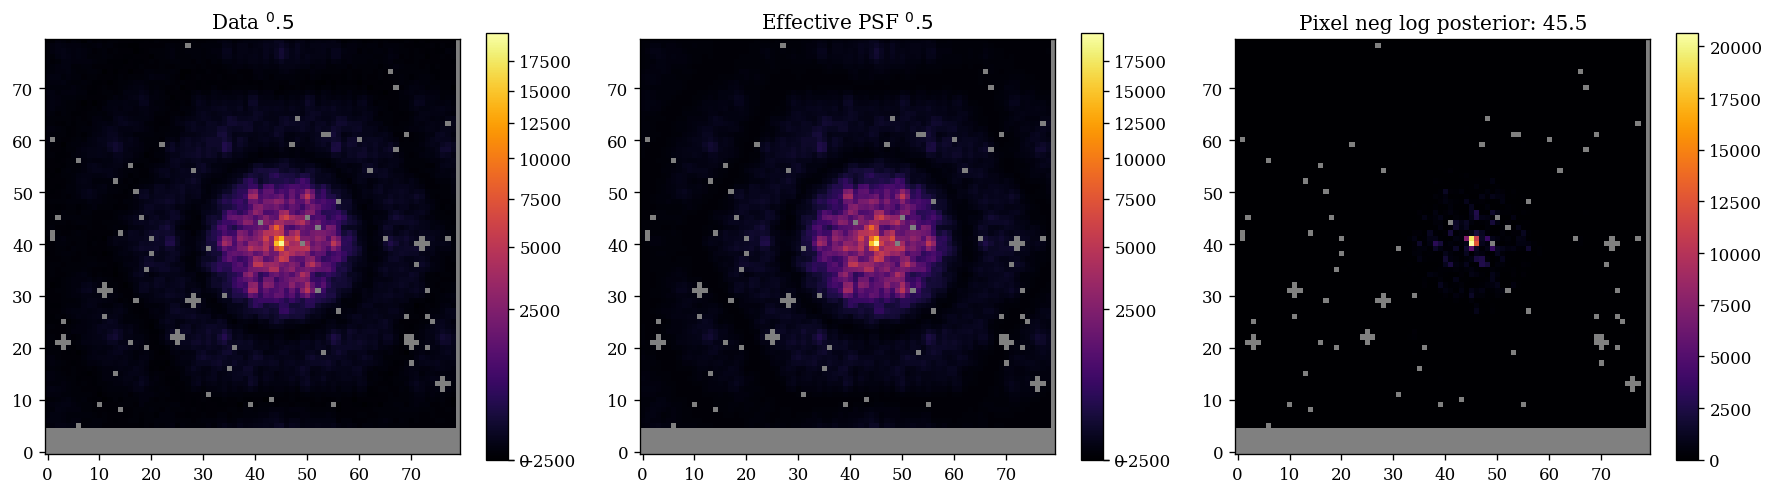

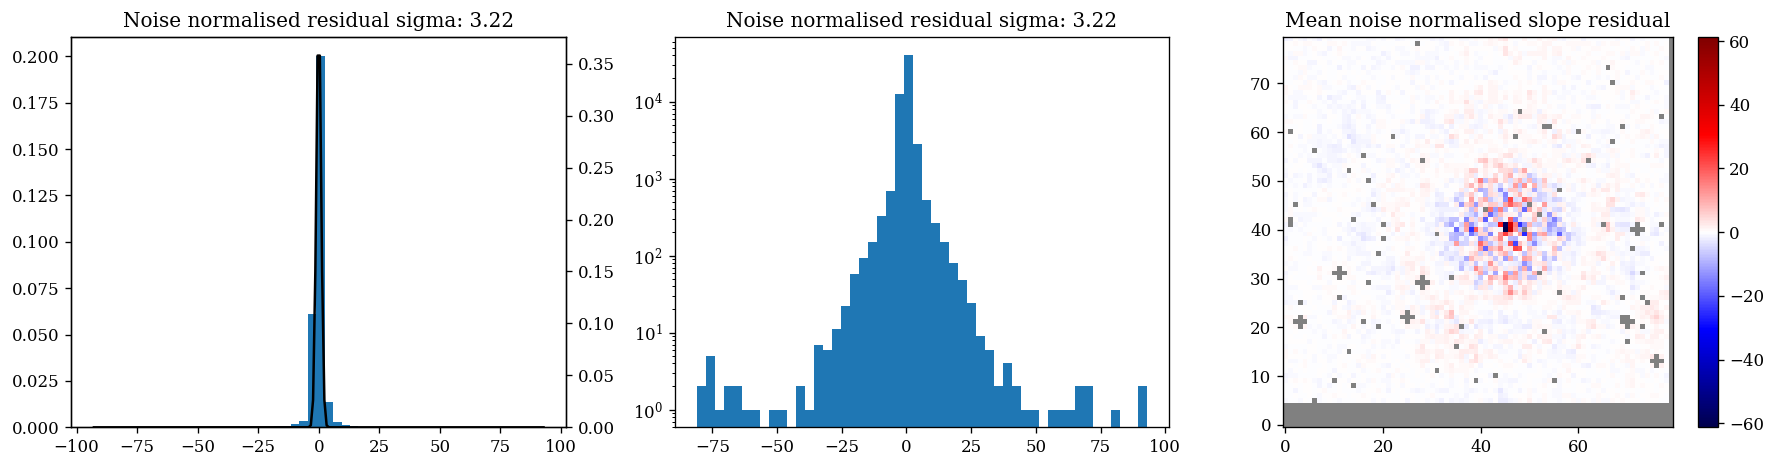

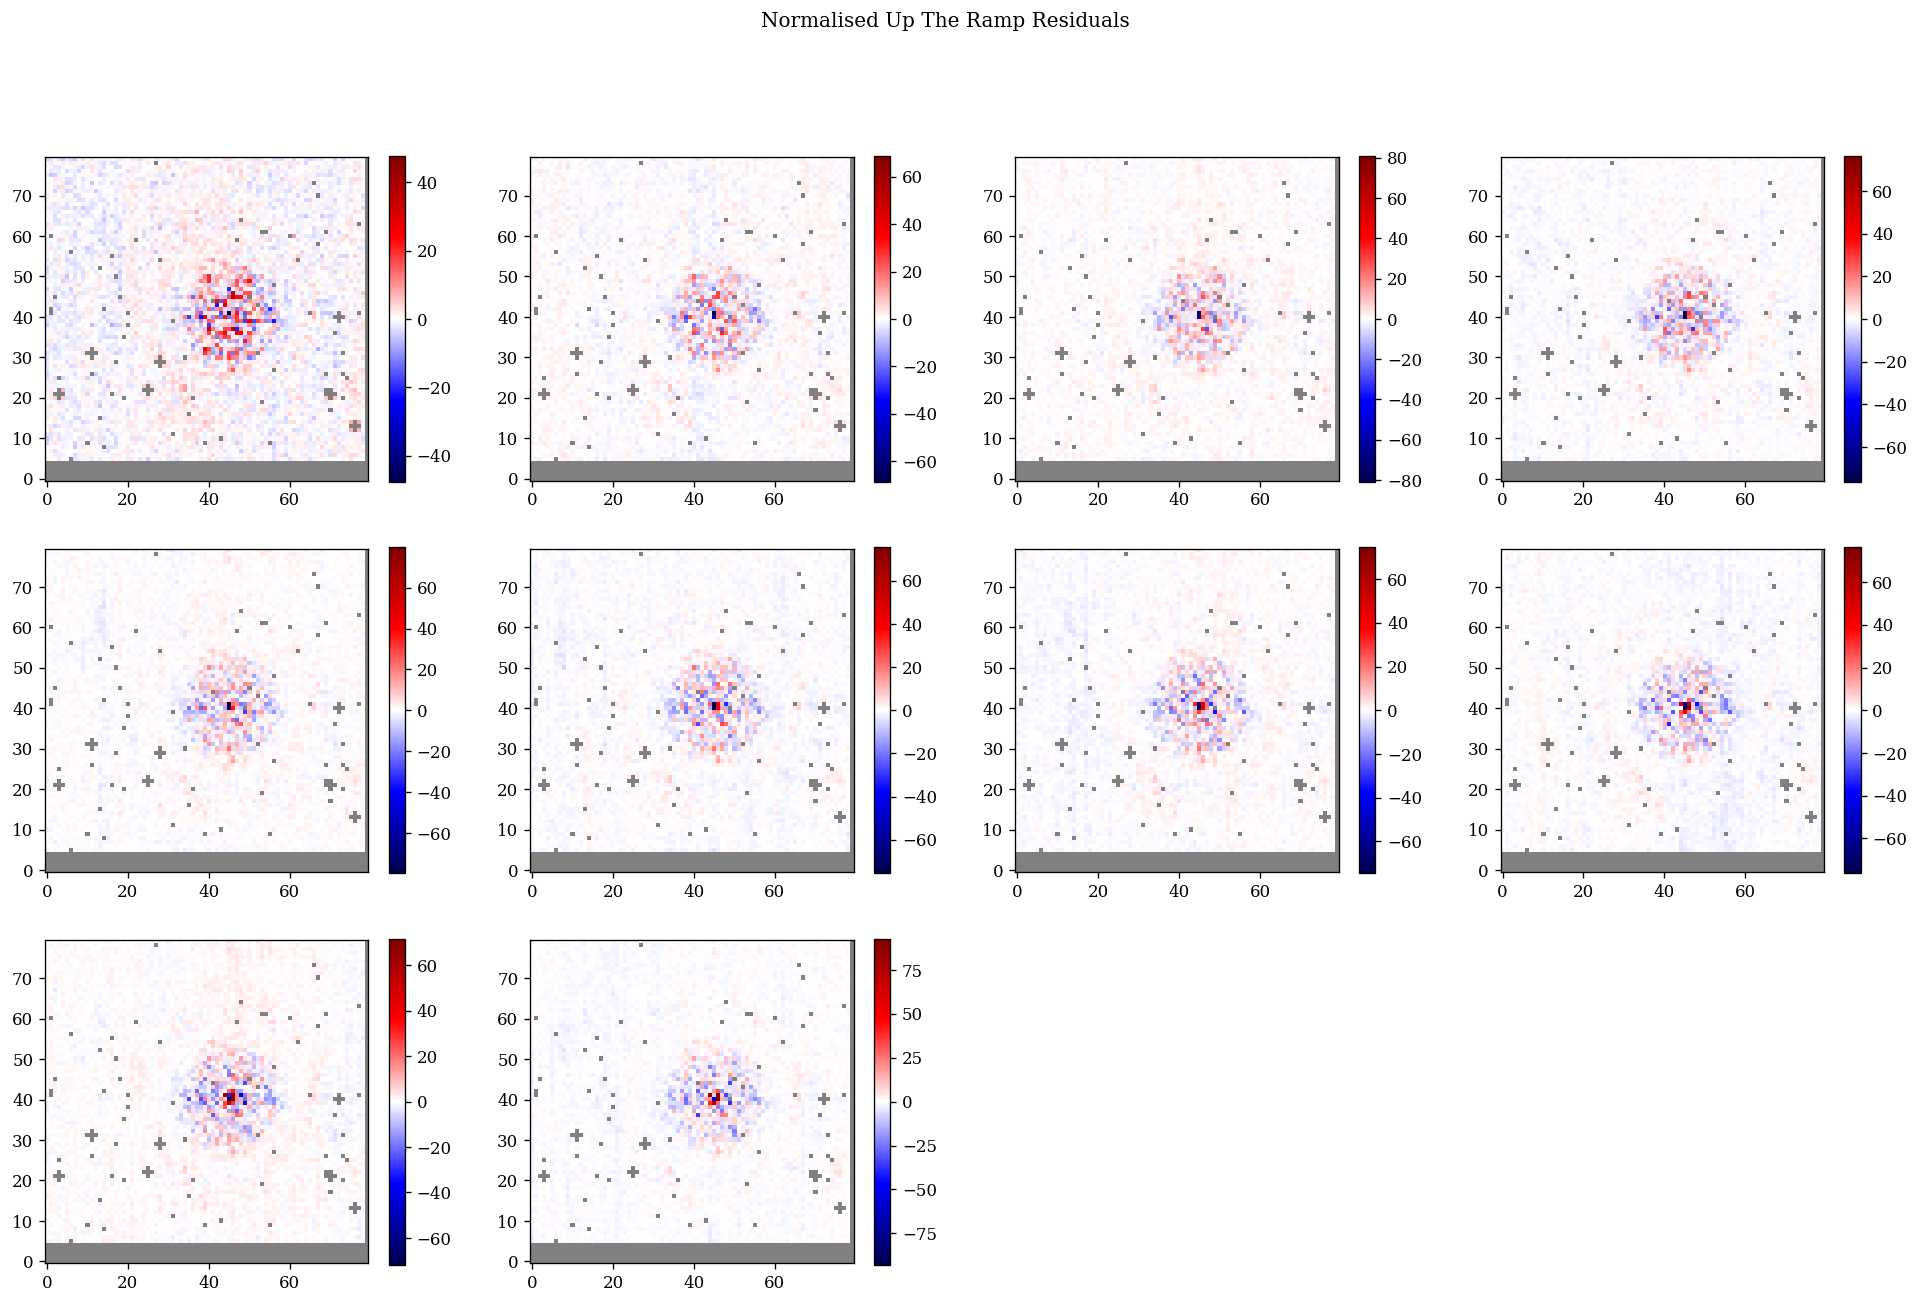

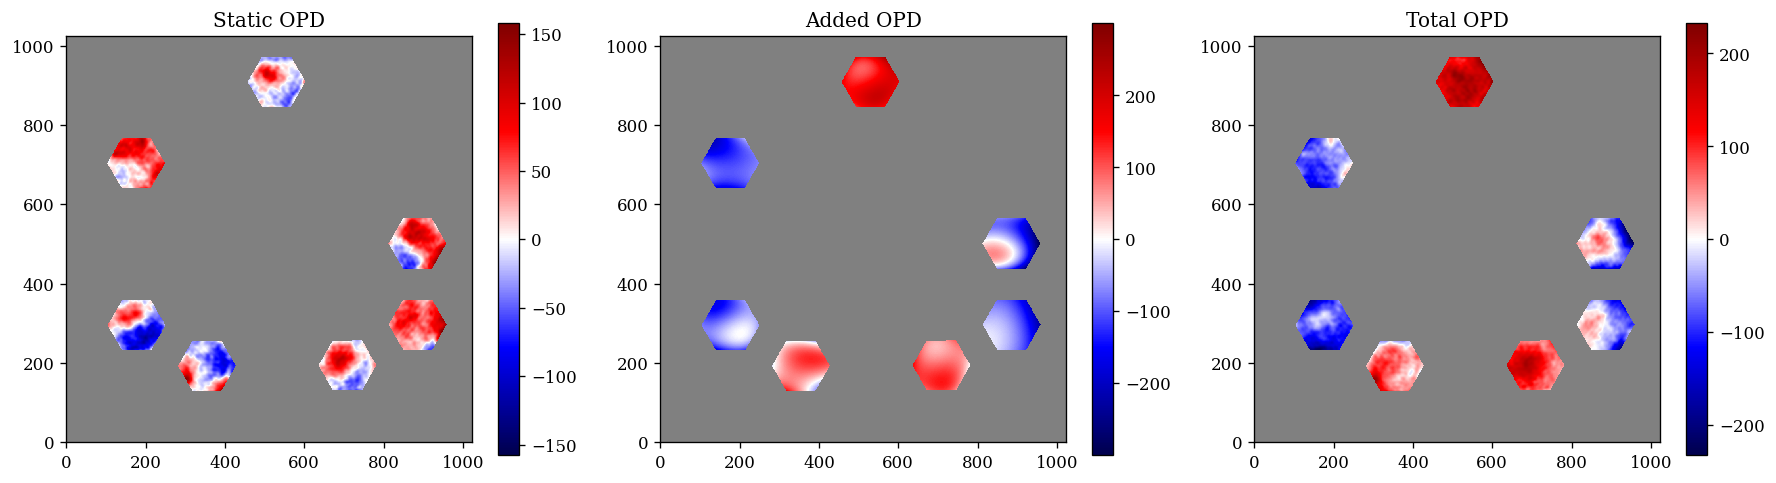

In [71]:
# new_exposures = [NewExposure(exp) for exp in exposures]

# for exp in new_exposures:
for exp in exposures:
    exp.print_summary()
    exp.summarise_fit(
        final_model,
        # model_fn,
        residuals=True,
        histograms=True,
        # flat_field=True,
        # up_the_ramp=True,
        up_the_ramp_norm=True,
        # full_bias=True,
        aberrations=True,
    )

In [64]:
def apply_bfe(final_model, exp, psf):
    flux = 10 ** final_model.fluxes[exp.key]
    norm_psf = psf / flux
    ramp = final_model.BFE.model(norm_psf, flux, exp.ngroups)
    dsample_fn = lambda x: dlu.downsample(x, 4, mean=False)
    ramp = vmap(dsample_fn)(ramp)
    return ramp

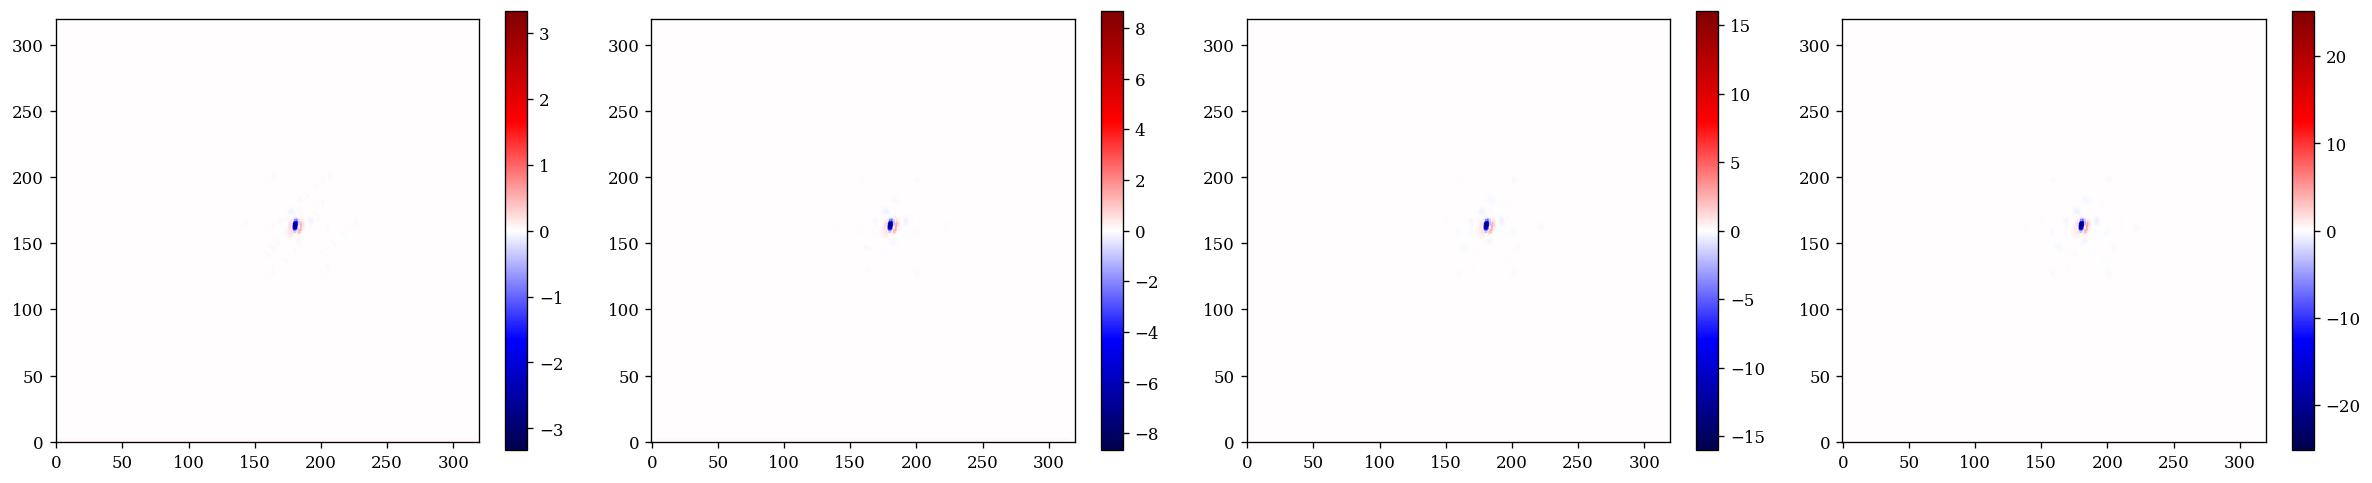

In [65]:
for exp in exposures:
    psf = final_model.model(exp, to_BFE=True)
    ramp, bleeding = final_model.EDM.bleeding_model(psf)

    ngroups = EDM.ngroups
    ramp_vals = (np.arange(ngroups) + 1) / ngroups
    inv_ramp = 1 / ramp_vals
    inv_order = np.arange(EDM.steps)[::-1]

    plt.figure(figsize=(20, 4))    
    for i in range(4):
        plt.subplot(1, 4, i+1)

        # Not normalised
        bleed_norm = bleeding[i]

        # Normalised
        # bleed_norm = bleeding[i] * inv_ramp[inv_order[i]]
        v = np.nanmax(np.abs(bleed_norm))
        plt.imshow(bleed_norm, cmap=seismic, vmin=-v, vmax=v)
        plt.colorbar()

    plt.tight_layout()
    plt.show()

In [ ]:
import os
from datetime import date


def create_folder():
    root_path = 'files/models/'

    # Get the current date as a string
    current_date = str(date.today())
    base_path = root_path + current_date

    # Check if a folder with the current date exists, and if not, create it
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    # Get a list of all directories in the current date folder
    dirs = [
        d
        for d in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, d))
    ]

    # Filter out directories that can't be converted to integers
    dirs = [d for d in dirs if d.isdigit()]

    # Convert the directory names to integers
    dirs = [int(d) for d in dirs]

    # Find the lowest integer that doesn't exist in the list
    next_int = 0
    while next_int in dirs:
        next_int += 1

    # Create a directory with the next integer
    next_dir = os.path.join(base_path, str(next_int))
    os.makedirs(next_dir)

    os.makedirs(next_dir + "/exposures/")

    return next_dir

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
from zodiax.experimental import serialise

save_path = create_folder()

# eqx.tree_serialise_leaves(f"{save_path}/CNN_BFE.eqx", final_model.BFE)
serialise(f"{save_path}/BFE", final_model.BFE)
serialise(f"{save_path}/AMI_mask", final_model.pupil_mask)
serialise(f"{save_path}/anisotropy", final_model.anisotropy)
serialise(f"{save_path}/reflectivities", final_model.optics.holes)
np.save(f"{save_path}/dark_current", final_model.detector.dark_current)


# for exp in exposures:
#     key = exp.key
# exp = exp.set('bias', model.biases[key])
# exp = exp.set('one_on_fs', model.one_on_fs[key])
# exp = exp.set('position', model.positions[key])
# exp = exp.set("aberrations", model.aberrations[key])
# exp = exp.set('flux', model.fluxes[key])
# serialise(f"{save_path}/exposures/{key}", exp)

print(save_path)

files/models/2024-04-23/0
